In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
mean_std_data = datasets.FashionMNIST('./FashionMNIST_data', train=True, download=True, transform=transforms.ToTensor()).train_data.float() / 255
mean = torch.mean(mean_std_data)
std = torch.std(mean_std_data)
print(mean, std)
print(mean_std_data.shape)

tensor(0.2860) tensor(0.3530)
torch.Size([60000, 28, 28])


In [5]:
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
           ])

In [12]:
def fashion_mnist(batch_size=50, valid=0, shuffle=True, transform=fashion_transform, path='./FashionMNIST_data'):
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    train_data.train_data = train_data.train_data[:30000, :, :]
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [20]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=5000)
print(len(train_loader), len(valid_loader))

500 100


In [26]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(256)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc4(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [27]:
models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [28]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    
    train_loss = {k: 0. for k in models}
    correct_train = {k: 0. for k in models}
    
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
            train_loss[k] += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct_train[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
        
    if log is not None:
        for k in models:
            train_loss[k] /= train_size
        correct_pct = {k: 100. * correct_train[k] / train_size for k in correct_train}
        for k in models:
            log[k].append((train_loss[k], correct_pct[k])) 

In [29]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [47]:
for epoch in range(1, 1451):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/25000 (0%)]	Losses default: 0.000015 bn: 0.000029 drop: 0.000022 both: 0.000129
Train Epoch: 1 [10000/25000 (40%)]	Losses default: 0.000019 bn: 0.005871 drop: 0.000009 both: 0.000553
Train Epoch: 1 [20000/25000 (80%)]	Losses default: 0.000037 bn: 0.000021 drop: 0.000922 both: 0.000165
Train Epoch: 1 [25000/25000 (100%)]	Losses default: 0.000015 bn: 0.001342 drop: 0.146922 both: 0.001089
Test set:
default: Loss: 1.1583	Accuracy: 4422.0/5000 (88%)
bn: Loss: 1.0117	Accuracy: 4425.0/5000 (88%)
drop: Loss: 1.0112	Accuracy: 4341.0/5000 (87%)
both: Loss: 0.9572	Accuracy: 4378.0/5000 (88%)

Train Epoch: 2 [0/25000 (0%)]	Losses default: 0.000009 bn: 0.001297 drop: 0.057938 both: 0.000909
Train Epoch: 2 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000003 drop: 0.036394 both: 0.000036
Train Epoch: 2 [20000/25000 (80%)]	Losses default: 0.000019 bn: 0.000026 drop: 0.003478 both: 0.000055
Train Epoch: 2 [25000/25000 (100%)]	Losses default: 0.000005 bn: 0.005183 drop: 0.000865

Train Epoch: 14 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000033 drop: 0.000035 both: 0.000113
Test set:
default: Loss: 1.2472	Accuracy: 4431.0/5000 (89%)
bn: Loss: 1.0057	Accuracy: 4413.0/5000 (88%)
drop: Loss: 0.9320	Accuracy: 4378.0/5000 (88%)
both: Loss: 0.9843	Accuracy: 4385.0/5000 (88%)

Train Epoch: 15 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000096 drop: 0.000091 both: 0.000503
Train Epoch: 15 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000029 drop: 0.000037 both: 0.000069
Train Epoch: 15 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000172 drop: 0.000050 both: 0.000050
Train Epoch: 15 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000036 drop: 0.000082 both: 0.000300
Test set:
default: Loss: 1.2508	Accuracy: 4437.0/5000 (89%)
bn: Loss: 1.0237	Accuracy: 4408.0/5000 (88%)
drop: Loss: 0.9310	Accuracy: 4391.0/5000 (88%)
both: Loss: 0.9718	Accuracy: 4397.0/5000 (88%)

Train Epoch: 16 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000575 drop: 0.000026

Train Epoch: 28 [10000/25000 (40%)]	Losses default: 0.128984 bn: 0.004832 drop: 0.000103 both: 0.000131
Train Epoch: 28 [20000/25000 (80%)]	Losses default: 0.003190 bn: 0.000165 drop: 0.000052 both: 0.001576
Train Epoch: 28 [25000/25000 (100%)]	Losses default: 0.000951 bn: 0.000554 drop: 0.000054 both: 0.000183
Test set:
default: Loss: 1.0491	Accuracy: 4411.0/5000 (88%)
bn: Loss: 1.0081	Accuracy: 4402.0/5000 (88%)
drop: Loss: 0.9790	Accuracy: 4378.0/5000 (88%)
both: Loss: 0.9491	Accuracy: 4399.0/5000 (88%)

Train Epoch: 29 [0/25000 (0%)]	Losses default: 0.000217 bn: 0.000065 drop: 0.000011 both: 0.000017
Train Epoch: 29 [10000/25000 (40%)]	Losses default: 0.000016 bn: 0.000200 drop: 0.000170 both: 0.000352
Train Epoch: 29 [20000/25000 (80%)]	Losses default: 0.000171 bn: 0.000023 drop: 0.000006 both: 0.000034
Train Epoch: 29 [25000/25000 (100%)]	Losses default: 0.010617 bn: 0.000010 drop: 0.000018 both: 0.000028
Test set:
default: Loss: 1.0859	Accuracy: 4416.0/5000 (88%)
bn: Loss: 0.980

Test set:
default: Loss: 1.1382	Accuracy: 4423.0/5000 (88%)
bn: Loss: 1.0162	Accuracy: 4425.0/5000 (88%)
drop: Loss: 0.9300	Accuracy: 4390.0/5000 (88%)
both: Loss: 0.9672	Accuracy: 4390.0/5000 (88%)

Train Epoch: 42 [0/25000 (0%)]	Losses default: 0.000006 bn: 0.000804 drop: 0.000015 both: 0.000047
Train Epoch: 42 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000122 drop: 0.000060 both: 0.014735
Train Epoch: 42 [20000/25000 (80%)]	Losses default: 0.000010 bn: 0.000026 drop: 0.000166 both: 0.000356
Train Epoch: 42 [25000/25000 (100%)]	Losses default: 0.000034 bn: 0.000016 drop: 0.000259 both: 0.000065
Test set:
default: Loss: 1.1443	Accuracy: 4424.0/5000 (88%)
bn: Loss: 0.9596	Accuracy: 4422.0/5000 (88%)
drop: Loss: 0.9226	Accuracy: 4404.0/5000 (88%)
both: Loss: 0.9803	Accuracy: 4369.0/5000 (87%)

Train Epoch: 43 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000044 drop: 0.000007 both: 0.000041
Train Epoch: 43 [10000/25000 (40%)]	Losses default: 0.000006 bn: 0.002681 drop: 0.000220 

Train Epoch: 55 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.006926 drop: 0.000037 both: 0.000044
Train Epoch: 55 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000045 drop: 0.000022 both: 0.000273
Train Epoch: 55 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.000052 both: 0.000064
Test set:
default: Loss: 1.2393	Accuracy: 4422.0/5000 (88%)
bn: Loss: 0.9796	Accuracy: 4408.0/5000 (88%)
drop: Loss: 0.9599	Accuracy: 4399.0/5000 (88%)
both: Loss: 0.9826	Accuracy: 4369.0/5000 (87%)

Train Epoch: 56 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.008380 drop: 0.000084 both: 0.009381
Train Epoch: 56 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000272 drop: 0.000182 both: 0.000216
Train Epoch: 56 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000025 drop: 0.000046 both: 0.014169
Train Epoch: 56 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000287 drop: 0.000030 both: 0.000032
Test set:
default: Loss: 1.2463	Accuracy: 4422.0/5000 (88%)
bn: Loss: 0.966

Test set:
default: Loss: 1.1045	Accuracy: 4419.0/5000 (88%)
bn: Loss: 1.0202	Accuracy: 4402.0/5000 (88%)
drop: Loss: 0.9833	Accuracy: 4394.0/5000 (88%)
both: Loss: 0.9868	Accuracy: 4384.0/5000 (88%)

Train Epoch: 69 [0/25000 (0%)]	Losses default: 0.000099 bn: 0.000481 drop: 0.027790 both: 0.003037
Train Epoch: 69 [10000/25000 (40%)]	Losses default: 0.000003 bn: 0.000411 drop: 0.000097 both: 0.000147
Train Epoch: 69 [20000/25000 (80%)]	Losses default: 0.000047 bn: 0.000038 drop: 0.000217 both: 0.000040
Train Epoch: 69 [25000/25000 (100%)]	Losses default: 0.000007 bn: 0.000042 drop: 0.000032 both: 0.000037
Test set:
default: Loss: 1.1126	Accuracy: 4419.0/5000 (88%)
bn: Loss: 0.9840	Accuracy: 4427.0/5000 (89%)
drop: Loss: 0.9803	Accuracy: 4374.0/5000 (87%)
both: Loss: 0.9719	Accuracy: 4393.0/5000 (88%)

Train Epoch: 70 [0/25000 (0%)]	Losses default: 0.000007 bn: 0.000112 drop: 0.000378 both: 0.000017
Train Epoch: 70 [10000/25000 (40%)]	Losses default: 0.000033 bn: 0.000362 drop: 0.000012 

Train Epoch: 82 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000009 drop: 0.000125 both: 0.000202
Train Epoch: 82 [20000/25000 (80%)]	Losses default: 0.000011 bn: 0.002181 drop: 0.000903 both: 0.000058
Train Epoch: 82 [25000/25000 (100%)]	Losses default: 0.000003 bn: 0.001085 drop: 0.000322 both: 0.000152
Test set:
default: Loss: 1.2123	Accuracy: 4422.0/5000 (88%)
bn: Loss: 0.9917	Accuracy: 4417.0/5000 (88%)
drop: Loss: 0.9010	Accuracy: 4394.0/5000 (88%)
both: Loss: 0.9954	Accuracy: 4397.0/5000 (88%)

Train Epoch: 83 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000011 drop: 0.000152 both: 0.000044
Train Epoch: 83 [10000/25000 (40%)]	Losses default: 0.000003 bn: 0.000312 drop: 0.000151 both: 0.000031
Train Epoch: 83 [20000/25000 (80%)]	Losses default: 0.000003 bn: 0.000021 drop: 0.000231 both: 0.011914
Train Epoch: 83 [25000/25000 (100%)]	Losses default: 0.000003 bn: 0.000463 drop: 0.000021 both: 0.000093
Test set:
default: Loss: 1.2181	Accuracy: 4420.0/5000 (88%)
bn: Loss: 0.993

Test set:
default: Loss: 1.2875	Accuracy: 4421.0/5000 (88%)
bn: Loss: 1.0207	Accuracy: 4399.0/5000 (88%)
drop: Loss: 1.1625	Accuracy: 4250.0/5000 (85%)
both: Loss: 0.9676	Accuracy: 4391.0/5000 (88%)

Train Epoch: 96 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000377 drop: 0.003932 both: 0.000030
Train Epoch: 96 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000011 drop: 0.012539 both: 0.000508
Train Epoch: 96 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000059 drop: 0.000073 both: 0.000191
Train Epoch: 96 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000019 drop: 0.000107 both: 0.000746
Test set:
default: Loss: 1.2912	Accuracy: 4424.0/5000 (88%)
bn: Loss: 1.0197	Accuracy: 4411.0/5000 (88%)
drop: Loss: 0.9817	Accuracy: 4394.0/5000 (88%)
both: Loss: 1.0022	Accuracy: 4386.0/5000 (88%)

Train Epoch: 97 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000080 drop: 0.000026 both: 0.000207
Train Epoch: 97 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000065 drop: 0.000093 

Train Epoch: 109 [10000/25000 (40%)]	Losses default: 0.000022 bn: 0.001149 drop: 0.000352 both: 0.000133
Train Epoch: 109 [20000/25000 (80%)]	Losses default: 0.000046 bn: 0.000612 drop: 0.000167 both: 0.000158
Train Epoch: 109 [25000/25000 (100%)]	Losses default: 0.000043 bn: 0.000015 drop: 0.000328 both: 0.000340
Test set:
default: Loss: 1.1302	Accuracy: 4422.0/5000 (88%)
bn: Loss: 1.0033	Accuracy: 4405.0/5000 (88%)
drop: Loss: 0.9793	Accuracy: 4372.0/5000 (87%)
both: Loss: 0.9780	Accuracy: 4385.0/5000 (88%)

Train Epoch: 110 [0/25000 (0%)]	Losses default: 0.000062 bn: 0.000038 drop: 0.000064 both: 0.000143
Train Epoch: 110 [10000/25000 (40%)]	Losses default: 0.000037 bn: 0.001310 drop: 0.000047 both: 0.000054
Train Epoch: 110 [20000/25000 (80%)]	Losses default: 0.000068 bn: 0.000081 drop: 0.000087 both: 0.000034
Train Epoch: 110 [25000/25000 (100%)]	Losses default: 0.000006 bn: 0.002327 drop: 0.000023 both: 0.000161
Test set:
default: Loss: 1.1340	Accuracy: 4422.0/5000 (88%)
bn: Loss

Train Epoch: 122 [25000/25000 (100%)]	Losses default: 0.000005 bn: 0.000218 drop: 0.000070 both: 0.000868
Test set:
default: Loss: 1.1980	Accuracy: 4422.0/5000 (88%)
bn: Loss: 1.0466	Accuracy: 4402.0/5000 (88%)
drop: Loss: 0.9317	Accuracy: 4401.0/5000 (88%)
both: Loss: 0.9875	Accuracy: 4378.0/5000 (88%)

Train Epoch: 123 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.029359 drop: 0.000025 both: 0.000027
Train Epoch: 123 [10000/25000 (40%)]	Losses default: 0.000005 bn: 0.000564 drop: 0.000105 both: 0.000091
Train Epoch: 123 [20000/25000 (80%)]	Losses default: 0.000007 bn: 0.000013 drop: 0.001700 both: 0.000027
Train Epoch: 123 [25000/25000 (100%)]	Losses default: 0.000006 bn: 0.000019 drop: 0.000017 both: 0.001236
Test set:
default: Loss: 1.2041	Accuracy: 4423.0/5000 (88%)
bn: Loss: 1.0031	Accuracy: 4432.0/5000 (89%)
drop: Loss: 0.9621	Accuracy: 4403.0/5000 (88%)
both: Loss: 0.9735	Accuracy: 4399.0/5000 (88%)

Train Epoch: 124 [0/25000 (0%)]	Losses default: 0.000002 bn: 0.000005 drop: 0.

Train Epoch: 136 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.001244 drop: 0.000112 both: 0.007507
Train Epoch: 136 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000009 drop: 0.000062 both: 0.003208
Train Epoch: 136 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000967 drop: 0.000434 both: 0.000013
Test set:
default: Loss: 1.2844	Accuracy: 4430.0/5000 (89%)
bn: Loss: 0.9485	Accuracy: 4419.0/5000 (88%)
drop: Loss: 0.9543	Accuracy: 4391.0/5000 (88%)
both: Loss: 0.9800	Accuracy: 4390.0/5000 (88%)

Train Epoch: 137 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000322 drop: 0.000186 both: 0.009741
Train Epoch: 137 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000015 drop: 0.000139 both: 0.000008
Train Epoch: 137 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000014 drop: 0.000103 both: 0.000447
Train Epoch: 137 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.013724 drop: 0.000028 both: 0.000119
Test set:
default: Loss: 1.2863	Accuracy: 4428.0/5000 (89%)
bn: Loss

Train Epoch: 149 [25000/25000 (100%)]	Losses default: 0.000007 bn: 0.001293 drop: 0.000124 both: 0.000261
Test set:
default: Loss: 1.1470	Accuracy: 4422.0/5000 (88%)
bn: Loss: 1.0068	Accuracy: 4413.0/5000 (88%)
drop: Loss: 0.9652	Accuracy: 4403.0/5000 (88%)
both: Loss: 1.0139	Accuracy: 4391.0/5000 (88%)

Train Epoch: 150 [0/25000 (0%)]	Losses default: 0.000005 bn: 0.000057 drop: 0.000034 both: 0.000019
Train Epoch: 150 [10000/25000 (40%)]	Losses default: 0.000005 bn: 0.000168 drop: 0.000510 both: 0.017132
Train Epoch: 150 [20000/25000 (80%)]	Losses default: 0.000007 bn: 0.000306 drop: 0.000074 both: 0.000016
Train Epoch: 150 [25000/25000 (100%)]	Losses default: 0.000045 bn: 0.000021 drop: 0.000020 both: 0.002842
Test set:
default: Loss: 1.1572	Accuracy: 4426.0/5000 (89%)
bn: Loss: 1.0075	Accuracy: 4406.0/5000 (88%)
drop: Loss: 0.9739	Accuracy: 4409.0/5000 (88%)
both: Loss: 1.0166	Accuracy: 4394.0/5000 (88%)

Train Epoch: 151 [0/25000 (0%)]	Losses default: 0.000007 bn: 0.002135 drop: 0.

Train Epoch: 163 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000078 drop: 0.133500 both: 0.000396
Train Epoch: 163 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000013 drop: 0.014450 both: 0.000016
Train Epoch: 163 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000021 drop: 0.060111 both: 0.000011
Test set:
default: Loss: 1.2623	Accuracy: 4430.0/5000 (89%)
bn: Loss: 0.9999	Accuracy: 4435.0/5000 (89%)
drop: Loss: 1.0526	Accuracy: 4320.0/5000 (86%)
both: Loss: 0.9925	Accuracy: 4393.0/5000 (88%)

Train Epoch: 164 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000016 drop: 0.000594 both: 0.003350
Train Epoch: 164 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.001827 drop: 0.003854 both: 0.000217
Train Epoch: 164 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000120 drop: 0.000277 both: 0.000089
Train Epoch: 164 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000062 drop: 0.000763 both: 0.001017
Test set:
default: Loss: 1.2667	Accuracy: 4433.0/5000 (89%)
bn: Loss

Train Epoch: 176 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000046 both: 0.000052
Test set:
default: Loss: 1.3381	Accuracy: 4425.0/5000 (88%)
bn: Loss: 0.9707	Accuracy: 4429.0/5000 (89%)
drop: Loss: 0.9474	Accuracy: 4409.0/5000 (88%)
both: Loss: 0.9898	Accuracy: 4390.0/5000 (88%)

Train Epoch: 177 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000042 drop: 0.000063 both: 0.000637
Train Epoch: 177 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.001619 drop: 0.000033 both: 0.000043
Train Epoch: 177 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000085 drop: 0.000149 both: 0.000007
Train Epoch: 177 [25000/25000 (100%)]	Losses default: 0.425745 bn: 0.000044 drop: 0.000063 both: 0.000008
Test set:
default: Loss: 1.3887	Accuracy: 4332.0/5000 (87%)
bn: Loss: 1.0140	Accuracy: 4424.0/5000 (88%)
drop: Loss: 0.9733	Accuracy: 4405.0/5000 (88%)
both: Loss: 0.9843	Accuracy: 4408.0/5000 (88%)

Train Epoch: 178 [0/25000 (0%)]	Losses default: 0.176004 bn: 0.000077 drop: 0.

Train Epoch: 190 [10000/25000 (40%)]	Losses default: 0.000007 bn: 0.000771 drop: 0.000012 both: 0.000009
Train Epoch: 190 [20000/25000 (80%)]	Losses default: 0.000002 bn: 0.000415 drop: 0.000040 both: 0.002630
Train Epoch: 190 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000004 drop: 0.000036 both: 0.000289
Test set:
default: Loss: 1.1642	Accuracy: 4435.0/5000 (89%)
bn: Loss: 0.9838	Accuracy: 4435.0/5000 (89%)
drop: Loss: 1.0174	Accuracy: 4395.0/5000 (88%)
both: Loss: 1.0016	Accuracy: 4380.0/5000 (88%)

Train Epoch: 191 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.001298 drop: 0.000016 both: 0.000152
Train Epoch: 191 [10000/25000 (40%)]	Losses default: 0.000013 bn: 0.000013 drop: 0.000028 both: 0.014373
Train Epoch: 191 [20000/25000 (80%)]	Losses default: 0.000015 bn: 0.000037 drop: 0.000010 both: 0.001955
Train Epoch: 191 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000548 drop: 0.000005 both: 0.027269
Test set:
default: Loss: 1.1736	Accuracy: 4436.0/5000 (89%)
bn: Loss

Train Epoch: 203 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000271 drop: 0.000301 both: 0.001052
Test set:
default: Loss: 1.2616	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.0087	Accuracy: 4417.0/5000 (88%)
drop: Loss: 1.0039	Accuracy: 4392.0/5000 (88%)
both: Loss: 1.0018	Accuracy: 4389.0/5000 (88%)

Train Epoch: 204 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000100 drop: 0.000014 both: 0.000041
Train Epoch: 204 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.190691 drop: 0.000724 both: 0.000018
Train Epoch: 204 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000179 drop: 0.000059 both: 0.000017
Train Epoch: 204 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000030 drop: 0.000019 both: 0.000029
Test set:
default: Loss: 1.2648	Accuracy: 4442.0/5000 (89%)
bn: Loss: 0.9816	Accuracy: 4421.0/5000 (88%)
drop: Loss: 0.9952	Accuracy: 4401.0/5000 (88%)
both: Loss: 0.9881	Accuracy: 4393.0/5000 (88%)

Train Epoch: 205 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000047 drop: 0.

Train Epoch: 217 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000112 drop: 0.000119 both: 0.000011
Train Epoch: 217 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000522 drop: 0.000050 both: 0.000178
Train Epoch: 217 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000027 drop: 0.000021 both: 0.000037
Test set:
default: Loss: 1.3289	Accuracy: 4440.0/5000 (89%)
bn: Loss: 1.0457	Accuracy: 4409.0/5000 (88%)
drop: Loss: 0.9995	Accuracy: 4386.0/5000 (88%)
both: Loss: 0.9633	Accuracy: 4380.0/5000 (88%)

Train Epoch: 218 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.030832 drop: 0.000027 both: 0.000216
Train Epoch: 218 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000050 drop: 0.000033 both: 0.000558
Train Epoch: 218 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000187 drop: 0.000192 both: 0.001660
Train Epoch: 218 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.002881 drop: 0.000068 both: 0.000259
Test set:
default: Loss: 1.3322	Accuracy: 4444.0/5000 (89%)
bn: Loss

Train Epoch: 230 [25000/25000 (100%)]	Losses default: 0.000019 bn: 0.000034 drop: 0.000015 both: 0.000833
Test set:
default: Loss: 1.1614	Accuracy: 4428.0/5000 (89%)
bn: Loss: 1.0173	Accuracy: 4387.0/5000 (88%)
drop: Loss: 1.0056	Accuracy: 4388.0/5000 (88%)
both: Loss: 0.9547	Accuracy: 4406.0/5000 (88%)

Train Epoch: 231 [0/25000 (0%)]	Losses default: 0.000006 bn: 0.000029 drop: 0.000401 both: 0.000023
Train Epoch: 231 [10000/25000 (40%)]	Losses default: 0.000019 bn: 0.000037 drop: 0.000015 both: 0.000158
Train Epoch: 231 [20000/25000 (80%)]	Losses default: 0.000006 bn: 0.000202 drop: 0.000081 both: 0.001396
Train Epoch: 231 [25000/25000 (100%)]	Losses default: 0.000004 bn: 0.000017 drop: 0.000060 both: 0.000053
Test set:
default: Loss: 1.1677	Accuracy: 4429.0/5000 (89%)
bn: Loss: 1.0236	Accuracy: 4417.0/5000 (88%)
drop: Loss: 1.0050	Accuracy: 4393.0/5000 (88%)
both: Loss: 0.9570	Accuracy: 4406.0/5000 (88%)

Train Epoch: 232 [0/25000 (0%)]	Losses default: 0.000024 bn: 0.000020 drop: 0.

Train Epoch: 244 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.001534 drop: 0.000005 both: 0.000196
Train Epoch: 244 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.001865 drop: 0.000026 both: 0.000016
Train Epoch: 244 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000590 drop: 0.000031 both: 0.000027
Test set:
default: Loss: 1.2610	Accuracy: 4442.0/5000 (89%)
bn: Loss: 1.0258	Accuracy: 4438.0/5000 (89%)
drop: Loss: 1.0145	Accuracy: 4411.0/5000 (88%)
both: Loss: 0.9871	Accuracy: 4398.0/5000 (88%)

Train Epoch: 245 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.052730 drop: 0.000017 both: 0.000021
Train Epoch: 245 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000102 drop: 0.000020 both: 0.000165
Train Epoch: 245 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000019 drop: 0.000020 both: 0.000010
Train Epoch: 245 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000660 drop: 0.000026 both: 0.000687
Test set:
default: Loss: 1.2688	Accuracy: 4440.0/5000 (89%)
bn: Loss

Train Epoch: 257 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000049 drop: 0.003125 both: 0.000256
Test set:
default: Loss: 1.3286	Accuracy: 4445.0/5000 (89%)
bn: Loss: 0.9661	Accuracy: 4449.0/5000 (89%)
drop: Loss: 1.0340	Accuracy: 4377.0/5000 (88%)
both: Loss: 1.0186	Accuracy: 4369.0/5000 (87%)

Train Epoch: 258 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000071 drop: 0.000034 both: 0.000076
Train Epoch: 258 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000179 drop: 0.000110 both: 0.000013
Train Epoch: 258 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000289 drop: 0.000114 both: 0.000200
Train Epoch: 258 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000155 drop: 0.005312 both: 0.000799
Test set:
default: Loss: 1.3336	Accuracy: 4443.0/5000 (89%)
bn: Loss: 0.9898	Accuracy: 4438.0/5000 (89%)
drop: Loss: 1.0135	Accuracy: 4369.0/5000 (87%)
both: Loss: 0.9872	Accuracy: 4400.0/5000 (88%)

Train Epoch: 259 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.001011 drop: 0.

Train Epoch: 271 [10000/25000 (40%)]	Losses default: 0.000009 bn: 0.000094 drop: 0.000020 both: 0.002930
Train Epoch: 271 [20000/25000 (80%)]	Losses default: 0.000024 bn: 0.000967 drop: 0.000016 both: 0.000074
Train Epoch: 271 [25000/25000 (100%)]	Losses default: 0.000006 bn: 0.000008 drop: 0.000028 both: 0.000046
Test set:
default: Loss: 1.1152	Accuracy: 4426.0/5000 (89%)
bn: Loss: 1.0328	Accuracy: 4409.0/5000 (88%)
drop: Loss: 0.9982	Accuracy: 4377.0/5000 (88%)
both: Loss: 0.9939	Accuracy: 4393.0/5000 (88%)

Train Epoch: 272 [0/25000 (0%)]	Losses default: 0.000004 bn: 0.000116 drop: 0.000650 both: 0.000072
Train Epoch: 272 [10000/25000 (40%)]	Losses default: 0.000035 bn: 0.003142 drop: 0.000007 both: 0.000334
Train Epoch: 272 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.002406 drop: 0.000035 both: 0.000031
Train Epoch: 272 [25000/25000 (100%)]	Losses default: 0.000034 bn: 0.000017 drop: 0.000323 both: 0.000160
Test set:
default: Loss: 1.1259	Accuracy: 4428.0/5000 (89%)
bn: Loss

Train Epoch: 284 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000195 drop: 0.000019 both: 0.000002
Test set:
default: Loss: 1.2499	Accuracy: 4420.0/5000 (88%)
bn: Loss: 0.9978	Accuracy: 4438.0/5000 (89%)
drop: Loss: 0.9917	Accuracy: 4384.0/5000 (88%)
both: Loss: 1.0070	Accuracy: 4392.0/5000 (88%)

Train Epoch: 285 [0/25000 (0%)]	Losses default: 0.000002 bn: 0.000022 drop: 0.000142 both: 0.000166
Train Epoch: 285 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000061 drop: 0.000335 both: 0.000698
Train Epoch: 285 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000079 both: 0.000026
Train Epoch: 285 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000011 drop: 0.000200 both: 0.040969
Test set:
default: Loss: 1.2586	Accuracy: 4425.0/5000 (88%)
bn: Loss: 1.0054	Accuracy: 4416.0/5000 (88%)
drop: Loss: 1.0190	Accuracy: 4391.0/5000 (88%)
both: Loss: 0.9797	Accuracy: 4395.0/5000 (88%)

Train Epoch: 286 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000064 drop: 0.

Train Epoch: 298 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000674 drop: 0.000584 both: 0.000021
Train Epoch: 298 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.003086 drop: 0.000214 both: 0.000240
Train Epoch: 298 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.001242 drop: 0.000555 both: 0.000460
Test set:
default: Loss: 1.3439	Accuracy: 4416.0/5000 (88%)
bn: Loss: 1.0480	Accuracy: 4399.0/5000 (88%)
drop: Loss: 0.9951	Accuracy: 4373.0/5000 (87%)
both: Loss: 1.0106	Accuracy: 4397.0/5000 (88%)

Train Epoch: 299 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000171 drop: 0.000393 both: 0.000043
Train Epoch: 299 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.004693 drop: 0.000070 both: 0.000410
Train Epoch: 299 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000338 drop: 0.000260 both: 0.000501
Train Epoch: 299 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.001272 drop: 0.000006 both: 0.000005
Test set:
default: Loss: 1.3509	Accuracy: 4418.0/5000 (88%)
bn: Loss

Train Epoch: 311 [25000/25000 (100%)]	Losses default: 0.000020 bn: 0.000004 drop: 0.003921 both: 0.000044
Test set:
default: Loss: 1.0927	Accuracy: 4439.0/5000 (89%)
bn: Loss: 1.0179	Accuracy: 4415.0/5000 (88%)
drop: Loss: 1.0186	Accuracy: 4391.0/5000 (88%)
both: Loss: 0.9921	Accuracy: 4423.0/5000 (88%)

Train Epoch: 312 [0/25000 (0%)]	Losses default: 0.000056 bn: 0.020161 drop: 0.000080 both: 0.002857
Train Epoch: 312 [10000/25000 (40%)]	Losses default: 0.000059 bn: 0.000004 drop: 0.000064 both: 0.000007
Train Epoch: 312 [20000/25000 (80%)]	Losses default: 0.000008 bn: 0.000006 drop: 0.000073 both: 0.000024
Train Epoch: 312 [25000/25000 (100%)]	Losses default: 0.000107 bn: 0.000513 drop: 0.001240 both: 0.000082
Test set:
default: Loss: 1.1024	Accuracy: 4441.0/5000 (89%)
bn: Loss: 0.9804	Accuracy: 4437.0/5000 (89%)
drop: Loss: 1.0442	Accuracy: 4375.0/5000 (88%)
both: Loss: 0.9987	Accuracy: 4413.0/5000 (88%)

Train Epoch: 313 [0/25000 (0%)]	Losses default: 0.000011 bn: 0.000006 drop: 0.

Train Epoch: 325 [10000/25000 (40%)]	Losses default: 0.000003 bn: 0.000267 drop: 0.000013 both: 0.000028
Train Epoch: 325 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000017 drop: 0.000004 both: 0.000065
Train Epoch: 325 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000549 drop: 0.000037 both: 0.000010
Test set:
default: Loss: 1.2239	Accuracy: 4444.0/5000 (89%)
bn: Loss: 1.0632	Accuracy: 4402.0/5000 (88%)
drop: Loss: 1.0688	Accuracy: 4402.0/5000 (88%)
both: Loss: 1.0163	Accuracy: 4395.0/5000 (88%)

Train Epoch: 326 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000595 drop: 0.000013 both: 0.004747
Train Epoch: 326 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000102 drop: 0.000012 both: 0.000048
Train Epoch: 326 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000008 drop: 0.000004 both: 0.000030
Train Epoch: 326 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000098 drop: 0.000208 both: 0.000186
Test set:
default: Loss: 1.2321	Accuracy: 4443.0/5000 (89%)
bn: Loss

Train Epoch: 338 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000234 drop: 0.000013 both: 0.000134
Test set:
default: Loss: 1.3110	Accuracy: 4444.0/5000 (89%)
bn: Loss: 1.0212	Accuracy: 4411.0/5000 (88%)
drop: Loss: 1.0634	Accuracy: 4396.0/5000 (88%)
both: Loss: 1.0249	Accuracy: 4395.0/5000 (88%)

Train Epoch: 339 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000412 drop: 0.000089 both: 0.000060
Train Epoch: 339 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.012667 drop: 0.000005 both: 0.000148
Train Epoch: 339 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000093 drop: 0.000034 both: 0.000020
Train Epoch: 339 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.001496 drop: 0.000009 both: 0.008369
Test set:
default: Loss: 1.3177	Accuracy: 4441.0/5000 (89%)
bn: Loss: 1.0300	Accuracy: 4412.0/5000 (88%)
drop: Loss: 1.0550	Accuracy: 4413.0/5000 (88%)
both: Loss: 1.0564	Accuracy: 4358.0/5000 (87%)

Train Epoch: 340 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000221 drop: 0.

Train Epoch: 352 [10000/25000 (40%)]	Losses default: 0.000034 bn: 0.000017 drop: 0.000103 both: 0.000047
Train Epoch: 352 [20000/25000 (80%)]	Losses default: 0.000236 bn: 0.000241 drop: 0.002216 both: 0.000024
Train Epoch: 352 [25000/25000 (100%)]	Losses default: 0.000080 bn: 0.000036 drop: 0.000565 both: 0.000207
Test set:
default: Loss: 1.0797	Accuracy: 4431.0/5000 (89%)
bn: Loss: 0.9913	Accuracy: 4430.0/5000 (89%)
drop: Loss: 1.0510	Accuracy: 4373.0/5000 (87%)
both: Loss: 1.0659	Accuracy: 4378.0/5000 (88%)

Train Epoch: 353 [0/25000 (0%)]	Losses default: 0.000166 bn: 0.000020 drop: 0.000063 both: 0.003243
Train Epoch: 353 [10000/25000 (40%)]	Losses default: 0.000017 bn: 0.000210 drop: 0.004238 both: 0.000634
Train Epoch: 353 [20000/25000 (80%)]	Losses default: 0.000014 bn: 0.000026 drop: 0.000103 both: 0.000073
Train Epoch: 353 [25000/25000 (100%)]	Losses default: 0.000008 bn: 0.058418 drop: 0.000006 both: 0.000581
Test set:
default: Loss: 1.0859	Accuracy: 4435.0/5000 (89%)
bn: Loss

Train Epoch: 365 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000072 drop: 0.000051 both: 0.000099
Test set:
default: Loss: 1.1971	Accuracy: 4442.0/5000 (89%)
bn: Loss: 1.0243	Accuracy: 4435.0/5000 (89%)
drop: Loss: 1.0427	Accuracy: 4397.0/5000 (88%)
both: Loss: 1.0382	Accuracy: 4388.0/5000 (88%)

Train Epoch: 366 [0/25000 (0%)]	Losses default: 0.000007 bn: 0.000006 drop: 0.000022 both: 0.000064
Train Epoch: 366 [10000/25000 (40%)]	Losses default: 0.000004 bn: 0.000041 drop: 0.000023 both: 0.000320
Train Epoch: 366 [20000/25000 (80%)]	Losses default: 0.000002 bn: 0.000005 drop: 0.000019 both: 0.000129
Train Epoch: 366 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000000 drop: 0.000003 both: 0.000062
Test set:
default: Loss: 1.2079	Accuracy: 4444.0/5000 (89%)
bn: Loss: 1.0537	Accuracy: 4420.0/5000 (88%)
drop: Loss: 1.0564	Accuracy: 4399.0/5000 (88%)
both: Loss: 1.0392	Accuracy: 4388.0/5000 (88%)

Train Epoch: 367 [0/25000 (0%)]	Losses default: 0.000005 bn: 0.000005 drop: 0.

Train Epoch: 379 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000076 drop: 0.208829 both: 0.000017
Train Epoch: 379 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.004920 drop: 0.004984 both: 0.000370
Train Epoch: 379 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000018 drop: 0.000157 both: 0.000161
Test set:
default: Loss: 1.3038	Accuracy: 4450.0/5000 (89%)
bn: Loss: 1.0759	Accuracy: 4416.0/5000 (88%)
drop: Loss: 1.0383	Accuracy: 4364.0/5000 (87%)
both: Loss: 1.0274	Accuracy: 4387.0/5000 (88%)

Train Epoch: 380 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000008 drop: 0.000063 both: 0.000148
Train Epoch: 380 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000490 drop: 0.000990 both: 0.000038
Train Epoch: 380 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000006 drop: 0.000146 both: 0.006732
Train Epoch: 380 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000090 drop: 0.000034 both: 0.000068
Test set:
default: Loss: 1.3108	Accuracy: 4447.0/5000 (89%)
bn: Loss

Train Epoch: 392 [25000/25000 (100%)]	Losses default: 0.027963 bn: 0.000047 drop: 0.012830 both: 0.000035
Test set:
default: Loss: 1.3310	Accuracy: 4346.0/5000 (87%)
bn: Loss: 1.0019	Accuracy: 4427.0/5000 (89%)
drop: Loss: 1.0277	Accuracy: 4370.0/5000 (87%)
both: Loss: 1.0441	Accuracy: 4392.0/5000 (88%)

Train Epoch: 393 [0/25000 (0%)]	Losses default: 0.031706 bn: 0.000444 drop: 0.000374 both: 0.000212
Train Epoch: 393 [10000/25000 (40%)]	Losses default: 0.000202 bn: 0.000052 drop: 0.000549 both: 0.000283
Train Epoch: 393 [20000/25000 (80%)]	Losses default: 0.000138 bn: 0.000299 drop: 0.000230 both: 0.000155
Train Epoch: 393 [25000/25000 (100%)]	Losses default: 0.000009 bn: 0.000010 drop: 0.000037 both: 0.000154
Test set:
default: Loss: 1.0873	Accuracy: 4404.0/5000 (88%)
bn: Loss: 0.9831	Accuracy: 4445.0/5000 (89%)
drop: Loss: 1.0149	Accuracy: 4400.0/5000 (88%)
both: Loss: 1.0476	Accuracy: 4385.0/5000 (88%)

Train Epoch: 394 [0/25000 (0%)]	Losses default: 0.001142 bn: 0.000066 drop: 0.

Train Epoch: 406 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000019 drop: 0.000029 both: 0.000009
Train Epoch: 406 [20000/25000 (80%)]	Losses default: 0.000031 bn: 0.000015 drop: 0.000026 both: 0.000072
Train Epoch: 406 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000033 drop: 0.000042 both: 0.000038
Test set:
default: Loss: 1.1516	Accuracy: 4423.0/5000 (88%)
bn: Loss: 0.9973	Accuracy: 4426.0/5000 (89%)
drop: Loss: 1.0436	Accuracy: 4388.0/5000 (88%)
both: Loss: 1.0007	Accuracy: 4386.0/5000 (88%)

Train Epoch: 407 [0/25000 (0%)]	Losses default: 0.000007 bn: 0.000106 drop: 0.000051 both: 0.005818
Train Epoch: 407 [10000/25000 (40%)]	Losses default: 0.000006 bn: 0.000005 drop: 0.000033 both: 0.002298
Train Epoch: 407 [20000/25000 (80%)]	Losses default: 0.000006 bn: 0.000055 drop: 0.000097 both: 0.000210
Train Epoch: 407 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000013 drop: 0.000020 both: 0.000243
Test set:
default: Loss: 1.1576	Accuracy: 4423.0/5000 (88%)
bn: Loss

Train Epoch: 419 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000021 drop: 0.000005 both: 0.000068
Test set:
default: Loss: 1.2493	Accuracy: 4425.0/5000 (88%)
bn: Loss: 1.0003	Accuracy: 4441.0/5000 (89%)
drop: Loss: 1.0535	Accuracy: 4392.0/5000 (88%)
both: Loss: 1.0679	Accuracy: 4384.0/5000 (88%)

Train Epoch: 420 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000020 drop: 0.000089 both: 0.000328
Train Epoch: 420 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000029 both: 0.000299
Train Epoch: 420 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000015 drop: 0.000013 both: 0.000008
Train Epoch: 420 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000319 drop: 0.000008 both: 0.000068
Test set:
default: Loss: 1.2575	Accuracy: 4427.0/5000 (89%)
bn: Loss: 1.0256	Accuracy: 4433.0/5000 (89%)
drop: Loss: 1.0711	Accuracy: 4395.0/5000 (88%)
both: Loss: 1.1049	Accuracy: 4355.0/5000 (87%)

Train Epoch: 421 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.012946 drop: 0.

Train Epoch: 433 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000180 drop: 0.007340 both: 0.000029
Train Epoch: 433 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.004600 drop: 0.001444 both: 0.000234
Train Epoch: 433 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000106 both: 0.001546
Test set:
default: Loss: 1.3392	Accuracy: 4428.0/5000 (89%)
bn: Loss: 1.0552	Accuracy: 4417.0/5000 (88%)
drop: Loss: 1.0664	Accuracy: 4355.0/5000 (87%)
both: Loss: 1.0947	Accuracy: 4370.0/5000 (87%)

Train Epoch: 434 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000019 drop: 0.000302 both: 0.000081
Train Epoch: 434 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000347 drop: 0.000626 both: 0.000585
Train Epoch: 434 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000073 drop: 0.000046 both: 0.000011
Train Epoch: 434 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000029 drop: 0.000045 both: 0.000004
Test set:
default: Loss: 1.3434	Accuracy: 4431.0/5000 (89%)
bn: Loss

Train Epoch: 446 [25000/25000 (100%)]	Losses default: 0.000107 bn: 0.000105 drop: 0.000817 both: 0.000022
Test set:
default: Loss: 1.1094	Accuracy: 4415.0/5000 (88%)
bn: Loss: 1.0449	Accuracy: 4414.0/5000 (88%)
drop: Loss: 1.0309	Accuracy: 4371.0/5000 (87%)
both: Loss: 1.0298	Accuracy: 4395.0/5000 (88%)

Train Epoch: 447 [0/25000 (0%)]	Losses default: 0.000143 bn: 0.017020 drop: 0.000037 both: 0.000596
Train Epoch: 447 [10000/25000 (40%)]	Losses default: 0.000008 bn: 0.000001 drop: 0.000129 both: 0.000009
Train Epoch: 447 [20000/25000 (80%)]	Losses default: 0.000236 bn: 0.000030 drop: 0.004525 both: 0.001153
Train Epoch: 447 [25000/25000 (100%)]	Losses default: 0.000275 bn: 0.000208 drop: 0.000025 both: 0.000865
Test set:
default: Loss: 1.1218	Accuracy: 4424.0/5000 (88%)
bn: Loss: 1.0304	Accuracy: 4411.0/5000 (88%)
drop: Loss: 1.0556	Accuracy: 4361.0/5000 (87%)
both: Loss: 1.0241	Accuracy: 4397.0/5000 (88%)

Train Epoch: 448 [0/25000 (0%)]	Losses default: 0.000064 bn: 0.000037 drop: 0.

Train Epoch: 460 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000011 drop: 0.000009 both: 0.000010
Train Epoch: 460 [20000/25000 (80%)]	Losses default: 0.000007 bn: 0.000060 drop: 0.000079 both: 0.000309
Train Epoch: 460 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000027 drop: 0.000242 both: 0.000037
Test set:
default: Loss: 1.2340	Accuracy: 4430.0/5000 (89%)
bn: Loss: 1.0613	Accuracy: 4431.0/5000 (89%)
drop: Loss: 1.0331	Accuracy: 4401.0/5000 (88%)
both: Loss: 1.0423	Accuracy: 4409.0/5000 (88%)

Train Epoch: 461 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000392 drop: 0.000011 both: 0.000017
Train Epoch: 461 [10000/25000 (40%)]	Losses default: 0.000003 bn: 0.000219 drop: 0.000028 both: 0.000021
Train Epoch: 461 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000155 drop: 0.000066 both: 0.002852
Train Epoch: 461 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000092 drop: 0.000020 both: 0.000067
Test set:
default: Loss: 1.2425	Accuracy: 4430.0/5000 (89%)
bn: Loss

Train Epoch: 473 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000030 drop: 0.000029 both: 0.000005
Test set:
default: Loss: 1.3177	Accuracy: 4442.0/5000 (89%)
bn: Loss: 1.0656	Accuracy: 4421.0/5000 (88%)
drop: Loss: 1.0818	Accuracy: 4378.0/5000 (88%)
both: Loss: 1.0626	Accuracy: 4391.0/5000 (88%)

Train Epoch: 474 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.001131 drop: 0.000025 both: 0.025405
Train Epoch: 474 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000006 drop: 0.000012 both: 0.000037
Train Epoch: 474 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000327 drop: 0.000003 both: 0.000558
Train Epoch: 474 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000384 drop: 0.000002 both: 0.000340
Test set:
default: Loss: 1.3266	Accuracy: 4445.0/5000 (89%)
bn: Loss: 0.9641	Accuracy: 4428.0/5000 (89%)
drop: Loss: 1.0693	Accuracy: 4375.0/5000 (88%)
both: Loss: 1.0311	Accuracy: 4394.0/5000 (88%)

Train Epoch: 475 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.004417 drop: 0.

Train Epoch: 487 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000011 both: 0.000009
Train Epoch: 487 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000038 drop: 0.000008 both: 0.001952
Train Epoch: 487 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000051 drop: 0.000008 both: 0.000004
Test set:
default: Loss: 1.3670	Accuracy: 4428.0/5000 (89%)
bn: Loss: 1.0332	Accuracy: 4411.0/5000 (88%)
drop: Loss: 1.0939	Accuracy: 4381.0/5000 (88%)
both: Loss: 1.0358	Accuracy: 4412.0/5000 (88%)

Train Epoch: 488 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000134 drop: 0.000003 both: 0.000047
Train Epoch: 488 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000017 drop: 0.000020 both: 0.000014
Train Epoch: 488 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000009 drop: 0.002477 both: 0.000042
Train Epoch: 488 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.000004 both: 0.000033
Test set:
default: Loss: 1.3718	Accuracy: 4434.0/5000 (89%)
bn: Loss

Train Epoch: 500 [25000/25000 (100%)]	Losses default: 0.000003 bn: 0.000001 drop: 0.000018 both: 0.000012
Test set:
default: Loss: 1.1556	Accuracy: 4425.0/5000 (88%)
bn: Loss: 1.0429	Accuracy: 4440.0/5000 (89%)
drop: Loss: 1.0544	Accuracy: 4393.0/5000 (88%)
both: Loss: 1.0210	Accuracy: 4384.0/5000 (88%)

Train Epoch: 501 [0/25000 (0%)]	Losses default: 0.000013 bn: 0.000002 drop: 0.000011 both: 0.000049
Train Epoch: 501 [10000/25000 (40%)]	Losses default: 0.000005 bn: 0.000012 drop: 0.000045 both: 0.000023
Train Epoch: 501 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000023 drop: 0.000005 both: 0.000094
Train Epoch: 501 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000188 drop: 0.002375 both: 0.008019
Test set:
default: Loss: 1.1640	Accuracy: 4423.0/5000 (88%)
bn: Loss: 1.0217	Accuracy: 4427.0/5000 (89%)
drop: Loss: 1.0884	Accuracy: 4371.0/5000 (87%)
both: Loss: 1.0025	Accuracy: 4406.0/5000 (88%)

Train Epoch: 502 [0/25000 (0%)]	Losses default: 0.000002 bn: 0.000047 drop: 0.

Train Epoch: 514 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000111 drop: 0.000019 both: 0.000059
Train Epoch: 514 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000200 drop: 0.000035 both: 0.004060
Train Epoch: 514 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000152 drop: 0.000015 both: 0.001702
Test set:
default: Loss: 1.2756	Accuracy: 4432.0/5000 (89%)
bn: Loss: 1.0011	Accuracy: 4415.0/5000 (88%)
drop: Loss: 1.0272	Accuracy: 4399.0/5000 (88%)
both: Loss: 1.0483	Accuracy: 4392.0/5000 (88%)

Train Epoch: 515 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000026 drop: 0.000021 both: 0.000236
Train Epoch: 515 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.007450 drop: 0.000122 both: 0.000031
Train Epoch: 515 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.042658 drop: 0.000006 both: 0.145980
Train Epoch: 515 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.003920 drop: 0.000069 both: 0.011928
Test set:
default: Loss: 1.2847	Accuracy: 4430.0/5000 (89%)
bn: Loss

Train Epoch: 527 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.004074 drop: 0.000008 both: 0.000041
Test set:
default: Loss: 1.3620	Accuracy: 4433.0/5000 (89%)
bn: Loss: 0.9759	Accuracy: 4462.0/5000 (89%)
drop: Loss: 1.0722	Accuracy: 4399.0/5000 (88%)
both: Loss: 1.0615	Accuracy: 4386.0/5000 (88%)

Train Epoch: 528 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000094 drop: 0.000048 both: 0.000117
Train Epoch: 528 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000007 both: 0.000003
Train Epoch: 528 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000054 drop: 0.000018 both: 0.000269
Train Epoch: 528 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000286 drop: 0.002307 both: 0.000472
Test set:
default: Loss: 1.3640	Accuracy: 4430.0/5000 (89%)
bn: Loss: 0.9961	Accuracy: 4434.0/5000 (89%)
drop: Loss: 1.1055	Accuracy: 4366.0/5000 (87%)
both: Loss: 1.0436	Accuracy: 4385.0/5000 (88%)

Train Epoch: 529 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000024 drop: 0.

Train Epoch: 541 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000013 drop: 0.000004 both: 0.000006
Train Epoch: 541 [20000/25000 (80%)]	Losses default: 0.000045 bn: 0.000068 drop: 0.000021 both: 0.028672
Train Epoch: 541 [25000/25000 (100%)]	Losses default: 0.000004 bn: 0.000010 drop: 0.000006 both: 0.000209
Test set:
default: Loss: 1.1222	Accuracy: 4442.0/5000 (89%)
bn: Loss: 0.9962	Accuracy: 4441.0/5000 (89%)
drop: Loss: 1.0219	Accuracy: 4384.0/5000 (88%)
both: Loss: 1.0726	Accuracy: 4381.0/5000 (88%)

Train Epoch: 542 [0/25000 (0%)]	Losses default: 0.000036 bn: 0.000046 drop: 0.000033 both: 0.000020
Train Epoch: 542 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000017 drop: 0.000017 both: 0.000002
Train Epoch: 542 [20000/25000 (80%)]	Losses default: 0.000035 bn: 0.000004 drop: 0.000011 both: 0.000004
Train Epoch: 542 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000015 drop: 0.000015 both: 0.000003
Test set:
default: Loss: 1.1325	Accuracy: 4438.0/5000 (89%)
bn: Loss

Train Epoch: 554 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000002 drop: 0.000183 both: 0.000004
Test set:
default: Loss: 1.2436	Accuracy: 4437.0/5000 (89%)
bn: Loss: 1.0481	Accuracy: 4405.0/5000 (88%)
drop: Loss: 1.0733	Accuracy: 4344.0/5000 (87%)
both: Loss: 1.0491	Accuracy: 4391.0/5000 (88%)

Train Epoch: 555 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.007902 drop: 0.000224 both: 0.000178
Train Epoch: 555 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000206 drop: 0.004419 both: 0.000007
Train Epoch: 555 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000146 drop: 0.000065 both: 0.000192
Train Epoch: 555 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000002 drop: 0.000010 both: 0.000042
Test set:
default: Loss: 1.2525	Accuracy: 4436.0/5000 (89%)
bn: Loss: 1.0445	Accuracy: 4404.0/5000 (88%)
drop: Loss: 1.0180	Accuracy: 4388.0/5000 (88%)
both: Loss: 1.0832	Accuracy: 4381.0/5000 (88%)

Train Epoch: 556 [0/25000 (0%)]	Losses default: 0.000002 bn: 0.001392 drop: 0.

Train Epoch: 568 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000022 drop: 0.000018 both: 0.006354
Train Epoch: 568 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000019 both: 0.000003
Train Epoch: 568 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000004 drop: 0.000002 both: 0.000032
Test set:
default: Loss: 1.3499	Accuracy: 4436.0/5000 (89%)
bn: Loss: 1.0457	Accuracy: 4421.0/5000 (88%)
drop: Loss: 1.0608	Accuracy: 4388.0/5000 (88%)
both: Loss: 1.0415	Accuracy: 4395.0/5000 (88%)

Train Epoch: 569 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000220 drop: 0.000021 both: 0.000034
Train Epoch: 569 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000014 drop: 0.000015 both: 0.000525
Train Epoch: 569 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000005 drop: 0.000103 both: 0.000050
Train Epoch: 569 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000019 drop: 0.000137 both: 0.000037
Test set:
default: Loss: 1.3552	Accuracy: 4433.0/5000 (89%)
bn: Loss

Train Epoch: 581 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000003 drop: 0.121869 both: 0.000369
Test set:
default: Loss: 1.1888	Accuracy: 4417.0/5000 (88%)
bn: Loss: 1.0279	Accuracy: 4439.0/5000 (89%)
drop: Loss: 1.0676	Accuracy: 4398.0/5000 (88%)
both: Loss: 1.0225	Accuracy: 4422.0/5000 (88%)

Train Epoch: 582 [0/25000 (0%)]	Losses default: 0.000008 bn: 0.000089 drop: 0.000047 both: 0.000009
Train Epoch: 582 [10000/25000 (40%)]	Losses default: 0.000004 bn: 0.025982 drop: 0.002691 both: 0.002000
Train Epoch: 582 [20000/25000 (80%)]	Losses default: 0.000042 bn: 0.001767 drop: 0.002352 both: 0.000117
Train Epoch: 582 [25000/25000 (100%)]	Losses default: 0.000009 bn: 0.000101 drop: 0.000017 both: 0.000019
Test set:
default: Loss: 1.1969	Accuracy: 4416.0/5000 (88%)
bn: Loss: 1.0155	Accuracy: 4443.0/5000 (89%)
drop: Loss: 1.0482	Accuracy: 4385.0/5000 (88%)
both: Loss: 1.0334	Accuracy: 4404.0/5000 (88%)

Train Epoch: 583 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000005 drop: 0.

Train Epoch: 595 [10000/25000 (40%)]	Losses default: 0.000004 bn: 0.132469 drop: 0.000047 both: 0.000463
Train Epoch: 595 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000080 drop: 0.000015 both: 0.000017
Train Epoch: 595 [25000/25000 (100%)]	Losses default: 0.000003 bn: 0.006007 drop: 0.000084 both: 0.028499
Test set:
default: Loss: 1.2839	Accuracy: 4421.0/5000 (88%)
bn: Loss: 1.0224	Accuracy: 4420.0/5000 (88%)
drop: Loss: 1.0552	Accuracy: 4392.0/5000 (88%)
both: Loss: 1.0710	Accuracy: 4393.0/5000 (88%)

Train Epoch: 596 [0/25000 (0%)]	Losses default: 0.000002 bn: 0.000045 drop: 0.000076 both: 0.001043
Train Epoch: 596 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000272 drop: 0.000028 both: 0.000059
Train Epoch: 596 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000323 drop: 0.000033 both: 0.000052
Train Epoch: 596 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000014 drop: 0.000045 both: 0.186445
Test set:
default: Loss: 1.2886	Accuracy: 4420.0/5000 (88%)
bn: Loss

Train Epoch: 608 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000487 drop: 0.000067 both: 0.000019
Test set:
default: Loss: 1.3499	Accuracy: 4432.0/5000 (89%)
bn: Loss: 1.0590	Accuracy: 4401.0/5000 (88%)
drop: Loss: 1.0999	Accuracy: 4376.0/5000 (88%)
both: Loss: 1.0423	Accuracy: 4388.0/5000 (88%)

Train Epoch: 609 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000011 drop: 0.000100 both: 0.000376
Train Epoch: 609 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000100 drop: 0.000054 both: 0.001297
Train Epoch: 609 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000003 both: 0.000018
Train Epoch: 609 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000023 drop: 0.000007 both: 0.000011
Test set:
default: Loss: 1.3572	Accuracy: 4430.0/5000 (89%)
bn: Loss: 1.0816	Accuracy: 4407.0/5000 (88%)
drop: Loss: 1.0811	Accuracy: 4383.0/5000 (88%)
both: Loss: 1.0574	Accuracy: 4385.0/5000 (88%)

Train Epoch: 610 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.002312 drop: 0.

Train Epoch: 622 [10000/25000 (40%)]	Losses default: 0.000663 bn: 0.000040 drop: 0.000034 both: 0.000043
Train Epoch: 622 [20000/25000 (80%)]	Losses default: 0.000575 bn: 0.000047 drop: 0.000001 both: 0.000008
Train Epoch: 622 [25000/25000 (100%)]	Losses default: 0.118349 bn: 0.000044 drop: 0.000011 both: 0.000225
Test set:
default: Loss: 1.2090	Accuracy: 4406.0/5000 (88%)
bn: Loss: 1.0653	Accuracy: 4421.0/5000 (88%)
drop: Loss: 1.0765	Accuracy: 4394.0/5000 (88%)
both: Loss: 1.0671	Accuracy: 4399.0/5000 (88%)

Train Epoch: 623 [0/25000 (0%)]	Losses default: 0.000204 bn: 0.000413 drop: 0.000047 both: 0.000011
Train Epoch: 623 [10000/25000 (40%)]	Losses default: 0.000073 bn: 0.000125 drop: 0.000017 both: 0.000028
Train Epoch: 623 [20000/25000 (80%)]	Losses default: 0.000268 bn: 0.000013 drop: 0.000004 both: 0.000475
Train Epoch: 623 [25000/25000 (100%)]	Losses default: 0.000020 bn: 0.000283 drop: 0.000052 both: 0.000173
Test set:
default: Loss: 1.1581	Accuracy: 4419.0/5000 (88%)
bn: Loss

Train Epoch: 635 [25000/25000 (100%)]	Losses default: 0.000004 bn: 0.000269 drop: 0.000020 both: 0.000054
Test set:
default: Loss: 1.1900	Accuracy: 4425.0/5000 (88%)
bn: Loss: 1.0531	Accuracy: 4418.0/5000 (88%)
drop: Loss: 1.0908	Accuracy: 4406.0/5000 (88%)
both: Loss: 1.0658	Accuracy: 4404.0/5000 (88%)

Train Epoch: 636 [0/25000 (0%)]	Losses default: 0.000010 bn: 0.000005 drop: 0.000016 both: 0.001528
Train Epoch: 636 [10000/25000 (40%)]	Losses default: 0.000003 bn: 0.000210 drop: 0.000003 both: 0.000092
Train Epoch: 636 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000031 drop: 0.000032 both: 0.000031
Train Epoch: 636 [25000/25000 (100%)]	Losses default: 0.000006 bn: 0.000077 drop: 0.000014 both: 0.000407
Test set:
default: Loss: 1.1959	Accuracy: 4425.0/5000 (88%)
bn: Loss: 1.0565	Accuracy: 4415.0/5000 (88%)
drop: Loss: 1.0954	Accuracy: 4394.0/5000 (88%)
both: Loss: 1.1060	Accuracy: 4384.0/5000 (88%)

Train Epoch: 637 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000012 drop: 0.

Train Epoch: 649 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000573 drop: 0.000062 both: 0.000016
Train Epoch: 649 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000054 drop: 0.000196 both: 0.000012
Train Epoch: 649 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.000010 both: 0.000007
Test set:
default: Loss: 1.2794	Accuracy: 4435.0/5000 (89%)
bn: Loss: 1.0533	Accuracy: 4434.0/5000 (89%)
drop: Loss: 1.0755	Accuracy: 4401.0/5000 (88%)
both: Loss: 1.0653	Accuracy: 4383.0/5000 (88%)

Train Epoch: 650 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000011 drop: 0.000110 both: 0.000033
Train Epoch: 650 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000006 drop: 0.000013 both: 0.000011
Train Epoch: 650 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.000013 both: 0.000215
Train Epoch: 650 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000132 drop: 0.000102 both: 0.000156
Test set:
default: Loss: 1.2866	Accuracy: 4433.0/5000 (89%)
bn: Loss

Train Epoch: 662 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000022 drop: 0.000068 both: 0.000003
Test set:
default: Loss: 1.3541	Accuracy: 4443.0/5000 (89%)
bn: Loss: 1.0252	Accuracy: 4414.0/5000 (88%)
drop: Loss: 1.0789	Accuracy: 4394.0/5000 (88%)
both: Loss: 1.0716	Accuracy: 4393.0/5000 (88%)

Train Epoch: 663 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000015 drop: 0.000011 both: 0.000001
Train Epoch: 663 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000005 drop: 0.000013 both: 0.010209
Train Epoch: 663 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000017 both: 0.000147
Train Epoch: 663 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000433 drop: 0.000006 both: 0.000089
Test set:
default: Loss: 1.3554	Accuracy: 4442.0/5000 (89%)
bn: Loss: 1.0273	Accuracy: 4421.0/5000 (88%)
drop: Loss: 1.0691	Accuracy: 4385.0/5000 (88%)
both: Loss: 1.1036	Accuracy: 4376.0/5000 (88%)

Train Epoch: 664 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000318 drop: 0.

Train Epoch: 676 [10000/25000 (40%)]	Losses default: 0.000016 bn: 0.000192 drop: 0.000020 both: 0.000121
Train Epoch: 676 [20000/25000 (80%)]	Losses default: 0.000006 bn: 0.000336 drop: 0.000014 both: 0.001210
Train Epoch: 676 [25000/25000 (100%)]	Losses default: 0.000019 bn: 0.000210 drop: 0.000007 both: 0.000023
Test set:
default: Loss: 1.1299	Accuracy: 4418.0/5000 (88%)
bn: Loss: 1.0269	Accuracy: 4435.0/5000 (89%)
drop: Loss: 1.0985	Accuracy: 4398.0/5000 (88%)
both: Loss: 1.0478	Accuracy: 4384.0/5000 (88%)

Train Epoch: 677 [0/25000 (0%)]	Losses default: 0.000010 bn: 0.000025 drop: 0.000056 both: 0.000150
Train Epoch: 677 [10000/25000 (40%)]	Losses default: 0.000047 bn: 0.000066 drop: 0.000004 both: 0.000026
Train Epoch: 677 [20000/25000 (80%)]	Losses default: 0.000016 bn: 0.000017 drop: 0.000023 both: 0.000003
Train Epoch: 677 [25000/25000 (100%)]	Losses default: 0.000050 bn: 0.000003 drop: 0.000003 both: 0.000005
Test set:
default: Loss: 1.1431	Accuracy: 4424.0/5000 (88%)
bn: Loss

Train Epoch: 689 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000012 drop: 0.000016 both: 0.000010
Test set:
default: Loss: 1.2593	Accuracy: 4427.0/5000 (89%)
bn: Loss: 1.0494	Accuracy: 4434.0/5000 (89%)
drop: Loss: 1.0821	Accuracy: 4395.0/5000 (88%)
both: Loss: 1.0943	Accuracy: 4382.0/5000 (88%)

Train Epoch: 690 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000005 drop: 0.000008 both: 0.000484
Train Epoch: 690 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000027 drop: 0.000013 both: 0.000226
Train Epoch: 690 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000023 drop: 0.000002 both: 0.000023
Train Epoch: 690 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000001 both: 0.000003
Test set:
default: Loss: 1.2681	Accuracy: 4429.0/5000 (89%)
bn: Loss: 1.0471	Accuracy: 4432.0/5000 (89%)
drop: Loss: 1.0850	Accuracy: 4398.0/5000 (88%)
both: Loss: 1.0617	Accuracy: 4398.0/5000 (88%)

Train Epoch: 691 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000007 drop: 0.

Train Epoch: 703 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000156 drop: 0.000037 both: 0.000211
Train Epoch: 703 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000806 drop: 0.000052 both: 0.000033
Train Epoch: 703 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000059 drop: 0.000003 both: 0.000009
Test set:
default: Loss: 1.3476	Accuracy: 4428.0/5000 (89%)
bn: Loss: 1.0596	Accuracy: 4437.0/5000 (89%)
drop: Loss: 1.1092	Accuracy: 4390.0/5000 (88%)
both: Loss: 1.0203	Accuracy: 4431.0/5000 (89%)

Train Epoch: 704 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000688 drop: 0.000010 both: 0.000021
Train Epoch: 704 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000008 both: 0.000010
Train Epoch: 704 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000011 both: 0.000026
Train Epoch: 704 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000019 both: 0.000071
Test set:
default: Loss: 1.3533	Accuracy: 4430.0/5000 (89%)
bn: Loss

Train Epoch: 716 [25000/25000 (100%)]	Losses default: 0.000926 bn: 0.000273 drop: 0.000002 both: 0.000673
Test set:
default: Loss: 1.0634	Accuracy: 4420.0/5000 (88%)
bn: Loss: 1.1027	Accuracy: 4426.0/5000 (89%)
drop: Loss: 1.0901	Accuracy: 4392.0/5000 (88%)
both: Loss: 1.1126	Accuracy: 4360.0/5000 (87%)

Train Epoch: 717 [0/25000 (0%)]	Losses default: 0.000036 bn: 0.000006 drop: 0.000006 both: 0.000044
Train Epoch: 717 [10000/25000 (40%)]	Losses default: 0.000006 bn: 0.000030 drop: 0.000017 both: 0.000019
Train Epoch: 717 [20000/25000 (80%)]	Losses default: 0.000171 bn: 0.000003 drop: 0.000010 both: 0.000021
Train Epoch: 717 [25000/25000 (100%)]	Losses default: 0.000012 bn: 0.000054 drop: 0.000002 both: 0.000525
Test set:
default: Loss: 1.0701	Accuracy: 4419.0/5000 (88%)
bn: Loss: 1.0764	Accuracy: 4434.0/5000 (89%)
drop: Loss: 1.0886	Accuracy: 4394.0/5000 (88%)
both: Loss: 1.1022	Accuracy: 4380.0/5000 (88%)

Train Epoch: 718 [0/25000 (0%)]	Losses default: 0.000030 bn: 0.000005 drop: 0.

Train Epoch: 730 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000005 drop: 0.000047 both: 0.000017
Train Epoch: 730 [20000/25000 (80%)]	Losses default: 0.000004 bn: 0.000007 drop: 0.000004 both: 0.000508
Train Epoch: 730 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000071 drop: 0.000012 both: 0.000102
Test set:
default: Loss: 1.2064	Accuracy: 4428.0/5000 (89%)
bn: Loss: 1.0734	Accuracy: 4443.0/5000 (89%)
drop: Loss: 1.0847	Accuracy: 4399.0/5000 (88%)
both: Loss: 1.0720	Accuracy: 4373.0/5000 (87%)

Train Epoch: 731 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000325 drop: 0.000155 both: 0.000017
Train Epoch: 731 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000001 drop: 0.000015 both: 0.000008
Train Epoch: 731 [20000/25000 (80%)]	Losses default: 0.000004 bn: 0.000497 drop: 0.000010 both: 0.000028
Train Epoch: 731 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000232 drop: 0.000065 both: 0.000012
Test set:
default: Loss: 1.2162	Accuracy: 4427.0/5000 (89%)
bn: Loss

Train Epoch: 743 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.037157 drop: 0.000003 both: 0.000013
Test set:
default: Loss: 1.3081	Accuracy: 4436.0/5000 (89%)
bn: Loss: 1.1014	Accuracy: 4420.0/5000 (88%)
drop: Loss: 1.1876	Accuracy: 4392.0/5000 (88%)
both: Loss: 1.0678	Accuracy: 4402.0/5000 (88%)

Train Epoch: 744 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000023 drop: 0.000004 both: 0.000004
Train Epoch: 744 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000013 drop: 0.000005 both: 0.000014
Train Epoch: 744 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000003 both: 0.000101
Train Epoch: 744 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000008 drop: 0.000008 both: 0.026321
Test set:
default: Loss: 1.3128	Accuracy: 4434.0/5000 (89%)
bn: Loss: 1.0687	Accuracy: 4417.0/5000 (88%)
drop: Loss: 1.1789	Accuracy: 4394.0/5000 (88%)
both: Loss: 1.0455	Accuracy: 4405.0/5000 (88%)

Train Epoch: 745 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000063 drop: 0.

Train Epoch: 757 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000009 drop: 0.000881 both: 0.003412
Train Epoch: 757 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000023 drop: 0.000008 both: 0.000003
Train Epoch: 757 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000019 drop: 0.000031 both: 0.000007
Test set:
default: Loss: 1.3572	Accuracy: 4431.0/5000 (89%)
bn: Loss: 1.0580	Accuracy: 4431.0/5000 (89%)
drop: Loss: 1.1426	Accuracy: 4381.0/5000 (88%)
both: Loss: 1.0466	Accuracy: 4394.0/5000 (88%)

Train Epoch: 758 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000011 drop: 0.000003 both: 0.000042
Train Epoch: 758 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000007 both: 0.000020
Train Epoch: 758 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000120 drop: 0.000021 both: 0.000097
Train Epoch: 758 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.004609 drop: 0.000015 both: 0.000007
Test set:
default: Loss: 1.3568	Accuracy: 4428.0/5000 (89%)
bn: Loss

Train Epoch: 770 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000023 drop: 0.000001 both: 0.000048
Test set:
default: Loss: 1.1467	Accuracy: 4433.0/5000 (89%)
bn: Loss: 1.0725	Accuracy: 4427.0/5000 (89%)
drop: Loss: 1.0843	Accuracy: 4412.0/5000 (88%)
both: Loss: 1.0406	Accuracy: 4420.0/5000 (88%)

Train Epoch: 771 [0/25000 (0%)]	Losses default: 0.000012 bn: 0.000020 drop: 0.000025 both: 0.000014
Train Epoch: 771 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000003 drop: 0.000009 both: 0.000030
Train Epoch: 771 [20000/25000 (80%)]	Losses default: 0.000007 bn: 0.000000 drop: 0.000020 both: 0.000006
Train Epoch: 771 [25000/25000 (100%)]	Losses default: 0.000005 bn: 0.000001 drop: 0.000210 both: 0.000037
Test set:
default: Loss: 1.1592	Accuracy: 4433.0/5000 (89%)
bn: Loss: 1.0694	Accuracy: 4429.0/5000 (89%)
drop: Loss: 1.1124	Accuracy: 4408.0/5000 (88%)
both: Loss: 1.0885	Accuracy: 4398.0/5000 (88%)

Train Epoch: 772 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000009 drop: 0.

Train Epoch: 784 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000460 drop: 0.000015 both: 0.000011
Train Epoch: 784 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000245 drop: 0.000025 both: 0.000300
Train Epoch: 784 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000145 drop: 0.000006 both: 0.000030
Test set:
default: Loss: 1.2854	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.0602	Accuracy: 4425.0/5000 (88%)
drop: Loss: 1.1317	Accuracy: 4413.0/5000 (88%)
both: Loss: 1.0913	Accuracy: 4391.0/5000 (88%)

Train Epoch: 785 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000001 both: 0.000011
Train Epoch: 785 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000004 both: 0.001142
Train Epoch: 785 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000027 drop: 0.000011 both: 0.000021
Train Epoch: 785 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000014 both: 0.000236
Test set:
default: Loss: 1.2927	Accuracy: 4438.0/5000 (89%)
bn: Loss

Train Epoch: 797 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000011 drop: 0.002927 both: 0.005759
Test set:
default: Loss: 1.3527	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.1101	Accuracy: 4398.0/5000 (88%)
drop: Loss: 1.1218	Accuracy: 4384.0/5000 (88%)
both: Loss: 1.1204	Accuracy: 4376.0/5000 (88%)

Train Epoch: 798 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000217 drop: 0.000007 both: 0.000357
Train Epoch: 798 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000072 drop: 0.000286 both: 0.003358
Train Epoch: 798 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000019 drop: 0.000013 both: 0.000108
Train Epoch: 798 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000058 drop: 0.000039 both: 0.000063
Test set:
default: Loss: 1.3545	Accuracy: 4432.0/5000 (89%)
bn: Loss: 1.0895	Accuracy: 4429.0/5000 (89%)
drop: Loss: 1.1313	Accuracy: 4388.0/5000 (88%)
both: Loss: 1.0529	Accuracy: 4370.0/5000 (87%)

Train Epoch: 799 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.

Train Epoch: 811 [10000/25000 (40%)]	Losses default: 0.000046 bn: 0.000146 drop: 0.000466 both: 0.000021
Train Epoch: 811 [20000/25000 (80%)]	Losses default: 0.000021 bn: 0.000039 drop: 0.000020 both: 0.000107
Train Epoch: 811 [25000/25000 (100%)]	Losses default: 0.000107 bn: 0.000013 drop: 0.000085 both: 0.000043
Test set:
default: Loss: 1.0858	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.0645	Accuracy: 4433.0/5000 (89%)
drop: Loss: 1.1311	Accuracy: 4377.0/5000 (88%)
both: Loss: 1.0634	Accuracy: 4382.0/5000 (88%)

Train Epoch: 812 [0/25000 (0%)]	Losses default: 0.000069 bn: 0.000057 drop: 0.000088 both: 0.000077
Train Epoch: 812 [10000/25000 (40%)]	Losses default: 0.000003 bn: 0.000032 drop: 0.000015 both: 0.000011
Train Epoch: 812 [20000/25000 (80%)]	Losses default: 0.000003 bn: 0.000017 drop: 0.000018 both: 0.000133
Train Epoch: 812 [25000/25000 (100%)]	Losses default: 0.000025 bn: 0.000001 drop: 0.000034 both: 0.000011
Test set:
default: Loss: 1.0923	Accuracy: 4437.0/5000 (89%)
bn: Loss

Train Epoch: 824 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.001223 drop: 0.000033 both: 0.000200
Test set:
default: Loss: 1.1906	Accuracy: 4448.0/5000 (89%)
bn: Loss: 1.0657	Accuracy: 4430.0/5000 (89%)
drop: Loss: 1.1463	Accuracy: 4393.0/5000 (88%)
both: Loss: 1.0304	Accuracy: 4396.0/5000 (88%)

Train Epoch: 825 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000060 drop: 0.000008 both: 0.006481
Train Epoch: 825 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000005 drop: 0.000008 both: 0.000039
Train Epoch: 825 [20000/25000 (80%)]	Losses default: 0.000002 bn: 0.000008 drop: 0.000009 both: 0.000017
Train Epoch: 825 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000079 drop: 0.000012 both: 0.000315
Test set:
default: Loss: 1.1999	Accuracy: 4448.0/5000 (89%)
bn: Loss: 1.0759	Accuracy: 4432.0/5000 (89%)
drop: Loss: 1.1573	Accuracy: 4398.0/5000 (88%)
both: Loss: 1.0551	Accuracy: 4383.0/5000 (88%)

Train Epoch: 826 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000311 drop: 0.

Train Epoch: 838 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000702 drop: 0.000002 both: 0.000023
Train Epoch: 838 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000005 drop: 0.000402 both: 0.000017
Train Epoch: 838 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000033 both: 0.000052
Test set:
default: Loss: 1.2880	Accuracy: 4448.0/5000 (89%)
bn: Loss: 1.0793	Accuracy: 4418.0/5000 (88%)
drop: Loss: 1.0909	Accuracy: 4379.0/5000 (88%)
both: Loss: 1.0207	Accuracy: 4410.0/5000 (88%)

Train Epoch: 839 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.000048 both: 0.000007
Train Epoch: 839 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000009 drop: 0.000161 both: 0.000150
Train Epoch: 839 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000853 both: 0.000009
Train Epoch: 839 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000012 drop: 0.000040 both: 0.000084
Test set:
default: Loss: 1.2934	Accuracy: 4447.0/5000 (89%)
bn: Loss

Train Epoch: 851 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000004 drop: 0.000002 both: 0.000004
Test set:
default: Loss: 1.3347	Accuracy: 4445.0/5000 (89%)
bn: Loss: 1.0813	Accuracy: 4430.0/5000 (89%)
drop: Loss: 1.1720	Accuracy: 4396.0/5000 (88%)
both: Loss: 1.0576	Accuracy: 4381.0/5000 (88%)

Train Epoch: 852 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000084 drop: 0.000009 both: 0.000018
Train Epoch: 852 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000561 drop: 0.000035 both: 0.000017
Train Epoch: 852 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000130 drop: 0.000008 both: 0.001573
Train Epoch: 852 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000002 both: 0.000726
Test set:
default: Loss: 1.3284	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.0762	Accuracy: 4430.0/5000 (89%)
drop: Loss: 1.1614	Accuracy: 4384.0/5000 (88%)
both: Loss: 1.0788	Accuracy: 4378.0/5000 (88%)

Train Epoch: 853 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000136 drop: 0.

Train Epoch: 865 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000005 both: 0.000053
Train Epoch: 865 [20000/25000 (80%)]	Losses default: 0.000005 bn: 0.001642 drop: 0.000004 both: 0.000051
Train Epoch: 865 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000018 drop: 0.000009 both: 0.000012
Test set:
default: Loss: 1.1573	Accuracy: 4419.0/5000 (88%)
bn: Loss: 1.0741	Accuracy: 4426.0/5000 (89%)
drop: Loss: 1.1644	Accuracy: 4397.0/5000 (88%)
both: Loss: 1.1151	Accuracy: 4364.0/5000 (87%)

Train Epoch: 866 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000435 drop: 0.000001 both: 0.071336
Train Epoch: 866 [10000/25000 (40%)]	Losses default: 0.000007 bn: 0.009576 drop: 0.000025 both: 0.000032
Train Epoch: 866 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000184 drop: 0.000055 both: 0.000018
Train Epoch: 866 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000003 both: 0.000135
Test set:
default: Loss: 1.1662	Accuracy: 4417.0/5000 (88%)
bn: Loss

Train Epoch: 878 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000004 drop: 0.000009 both: 0.000003
Test set:
default: Loss: 1.2564	Accuracy: 4423.0/5000 (88%)
bn: Loss: 1.0839	Accuracy: 4420.0/5000 (88%)
drop: Loss: 1.1494	Accuracy: 4384.0/5000 (88%)
both: Loss: 1.0809	Accuracy: 4365.0/5000 (87%)

Train Epoch: 879 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000141 drop: 0.000020 both: 0.000008
Train Epoch: 879 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000027 drop: 0.000748 both: 0.000003
Train Epoch: 879 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000408 drop: 0.000042 both: 0.000012
Train Epoch: 879 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000023 both: 0.003971
Test set:
default: Loss: 1.2621	Accuracy: 4422.0/5000 (88%)
bn: Loss: 1.1016	Accuracy: 4402.0/5000 (88%)
drop: Loss: 1.1243	Accuracy: 4390.0/5000 (88%)
both: Loss: 1.0556	Accuracy: 4378.0/5000 (88%)

Train Epoch: 880 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000052 drop: 0.

Train Epoch: 892 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000002 both: 0.000048
Train Epoch: 892 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000000 drop: 0.000006 both: 0.000054
Train Epoch: 892 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000292 both: 0.000003
Test set:
default: Loss: 1.3220	Accuracy: 4428.0/5000 (89%)
bn: Loss: 1.0807	Accuracy: 4445.0/5000 (89%)
drop: Loss: 1.1949	Accuracy: 4391.0/5000 (88%)
both: Loss: 1.0753	Accuracy: 4382.0/5000 (88%)

Train Epoch: 893 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000006 drop: 0.000003 both: 0.000006
Train Epoch: 893 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000084 drop: 0.000004 both: 0.000037
Train Epoch: 893 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000056 drop: 0.000006 both: 0.000078
Train Epoch: 893 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000005 both: 0.000120
Test set:
default: Loss: 1.3221	Accuracy: 4425.0/5000 (88%)
bn: Loss

Train Epoch: 905 [25000/25000 (100%)]	Losses default: 0.000063 bn: 0.000019 drop: 0.000010 both: 0.000019
Test set:
default: Loss: 1.0926	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.0852	Accuracy: 4420.0/5000 (88%)
drop: Loss: 1.2864	Accuracy: 4384.0/5000 (88%)
both: Loss: 1.0335	Accuracy: 4388.0/5000 (88%)

Train Epoch: 906 [0/25000 (0%)]	Losses default: 0.000018 bn: 0.003332 drop: 0.000001 both: 0.000034
Train Epoch: 906 [10000/25000 (40%)]	Losses default: 0.000004 bn: 0.000030 drop: 0.000002 both: 0.000012
Train Epoch: 906 [20000/25000 (80%)]	Losses default: 0.000003 bn: 0.000013 drop: 0.000001 both: 0.000060
Train Epoch: 906 [25000/25000 (100%)]	Losses default: 0.000026 bn: 0.000398 drop: 0.000001 both: 0.000021
Test set:
default: Loss: 1.1055	Accuracy: 4442.0/5000 (89%)
bn: Loss: 1.0887	Accuracy: 4422.0/5000 (88%)
drop: Loss: 1.2971	Accuracy: 4406.0/5000 (88%)
both: Loss: 1.0791	Accuracy: 4399.0/5000 (88%)

Train Epoch: 907 [0/25000 (0%)]	Losses default: 0.000003 bn: 0.000806 drop: 0.

Train Epoch: 919 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000005 drop: 0.000004 both: 0.000088
Train Epoch: 919 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.002642 drop: 0.000032 both: 0.008520
Train Epoch: 919 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.002951 drop: 0.000019 both: 0.000022
Test set:
default: Loss: 1.2383	Accuracy: 4446.0/5000 (89%)
bn: Loss: 1.1293	Accuracy: 4410.0/5000 (88%)
drop: Loss: 1.2258	Accuracy: 4391.0/5000 (88%)
both: Loss: 1.0603	Accuracy: 4403.0/5000 (88%)

Train Epoch: 920 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.000020 both: 0.000008
Train Epoch: 920 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.047938 drop: 0.000125 both: 0.000019
Train Epoch: 920 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000003 both: 0.000704
Train Epoch: 920 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000311 both: 0.000053
Test set:
default: Loss: 1.2455	Accuracy: 4445.0/5000 (89%)
bn: Loss

Train Epoch: 932 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000000 both: 0.000013
Test set:
default: Loss: 1.3119	Accuracy: 4445.0/5000 (89%)
bn: Loss: 1.0825	Accuracy: 4404.0/5000 (88%)
drop: Loss: 1.2671	Accuracy: 4377.0/5000 (88%)
both: Loss: 1.0809	Accuracy: 4399.0/5000 (88%)

Train Epoch: 933 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000196 drop: 0.000002 both: 0.000028
Train Epoch: 933 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000002 both: 0.000005
Train Epoch: 933 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000132 drop: 0.000010 both: 0.000021
Train Epoch: 933 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.036386 drop: 0.000009 both: 0.011686
Test set:
default: Loss: 1.3150	Accuracy: 4445.0/5000 (89%)
bn: Loss: 1.1323	Accuracy: 4381.0/5000 (88%)
drop: Loss: 1.2828	Accuracy: 4392.0/5000 (88%)
both: Loss: 1.1100	Accuracy: 4377.0/5000 (88%)

Train Epoch: 934 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000023 drop: 0.

Train Epoch: 946 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000128 drop: 0.000052 both: 0.000624
Train Epoch: 946 [20000/25000 (80%)]	Losses default: 0.000010 bn: 0.000107 drop: 0.000008 both: 0.000057
Train Epoch: 946 [25000/25000 (100%)]	Losses default: 0.000007 bn: 0.000033 drop: 0.000033 both: 0.000183
Test set:
default: Loss: 1.1080	Accuracy: 4422.0/5000 (88%)
bn: Loss: 1.1125	Accuracy: 4412.0/5000 (88%)
drop: Loss: 1.2058	Accuracy: 4376.0/5000 (88%)
both: Loss: 1.0700	Accuracy: 4373.0/5000 (87%)

Train Epoch: 947 [0/25000 (0%)]	Losses default: 0.000004 bn: 0.001430 drop: 0.000006 both: 0.003173
Train Epoch: 947 [10000/25000 (40%)]	Losses default: 0.000029 bn: 0.000016 drop: 0.020908 both: 0.001426
Train Epoch: 947 [20000/25000 (80%)]	Losses default: 0.000003 bn: 0.000007 drop: 0.000016 both: 0.000069
Train Epoch: 947 [25000/25000 (100%)]	Losses default: 0.000009 bn: 0.000062 drop: 0.000008 both: 0.003981
Test set:
default: Loss: 1.1091	Accuracy: 4422.0/5000 (88%)
bn: Loss

Train Epoch: 959 [25000/25000 (100%)]	Losses default: 0.000004 bn: 0.000012 drop: 0.000034 both: 0.000113
Test set:
default: Loss: 1.1806	Accuracy: 4425.0/5000 (88%)
bn: Loss: 1.0850	Accuracy: 4414.0/5000 (88%)
drop: Loss: 1.2416	Accuracy: 4367.0/5000 (87%)
both: Loss: 1.0576	Accuracy: 4392.0/5000 (88%)

Train Epoch: 960 [0/25000 (0%)]	Losses default: 0.000003 bn: 0.000340 drop: 0.166040 both: 0.000050
Train Epoch: 960 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000002 drop: 0.001872 both: 0.000073
Train Epoch: 960 [20000/25000 (80%)]	Losses default: 0.000003 bn: 0.000005 drop: 0.007516 both: 0.000035
Train Epoch: 960 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000015 drop: 0.000005 both: 0.000010
Test set:
default: Loss: 1.1871	Accuracy: 4429.0/5000 (89%)
bn: Loss: 1.0862	Accuracy: 4428.0/5000 (89%)
drop: Loss: 1.2093	Accuracy: 4376.0/5000 (88%)
both: Loss: 1.0596	Accuracy: 4401.0/5000 (88%)

Train Epoch: 961 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000169 drop: 0.

Train Epoch: 973 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000039 drop: 0.000008 both: 0.000011
Train Epoch: 973 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000056 drop: 0.000005 both: 0.000008
Train Epoch: 973 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000295 drop: 0.000002 both: 0.000049
Test set:
default: Loss: 1.2804	Accuracy: 4434.0/5000 (89%)
bn: Loss: 1.0730	Accuracy: 4420.0/5000 (88%)
drop: Loss: 1.2255	Accuracy: 4398.0/5000 (88%)
both: Loss: 1.0911	Accuracy: 4384.0/5000 (88%)

Train Epoch: 974 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000021 drop: 0.000006 both: 0.000005
Train Epoch: 974 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000072 drop: 0.000003 both: 0.035306
Train Epoch: 974 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.005944 drop: 0.000015 both: 0.016467
Train Epoch: 974 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000037 drop: 0.000003 both: 0.000046
Test set:
default: Loss: 1.2888	Accuracy: 4432.0/5000 (89%)
bn: Loss

Train Epoch: 986 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000016 both: 0.000036
Test set:
default: Loss: 1.3327	Accuracy: 4442.0/5000 (89%)
bn: Loss: 1.0973	Accuracy: 4440.0/5000 (89%)
drop: Loss: 1.2208	Accuracy: 4380.0/5000 (88%)
both: Loss: 1.0538	Accuracy: 4397.0/5000 (88%)

Train Epoch: 987 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000006 drop: 0.000006 both: 0.000042
Train Epoch: 987 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000125 both: 0.000040
Train Epoch: 987 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000264 drop: 0.000010 both: 0.000113
Train Epoch: 987 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000412 both: 0.000013
Test set:
default: Loss: 1.3364	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.1143	Accuracy: 4422.0/5000 (88%)
drop: Loss: 1.2221	Accuracy: 4356.0/5000 (87%)
both: Loss: 1.1045	Accuracy: 4373.0/5000 (87%)

Train Epoch: 988 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000021 drop: 0.

Train Epoch: 1000 [10000/25000 (40%)]	Losses default: 0.000019 bn: 0.000335 drop: 0.000026 both: 0.000010
Train Epoch: 1000 [20000/25000 (80%)]	Losses default: 0.000006 bn: 0.000011 drop: 0.000061 both: 0.000050
Train Epoch: 1000 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000331 drop: 0.000002 both: 0.000008
Test set:
default: Loss: 1.1765	Accuracy: 4422.0/5000 (88%)
bn: Loss: 1.1355	Accuracy: 4434.0/5000 (89%)
drop: Loss: 1.1943	Accuracy: 4392.0/5000 (88%)
both: Loss: 1.0411	Accuracy: 4407.0/5000 (88%)

Train Epoch: 1001 [0/25000 (0%)]	Losses default: 0.000006 bn: 0.000006 drop: 0.000001 both: 0.000083
Train Epoch: 1001 [10000/25000 (40%)]	Losses default: 0.000006 bn: 0.000021 drop: 0.000045 both: 0.000245
Train Epoch: 1001 [20000/25000 (80%)]	Losses default: 0.000002 bn: 0.000076 drop: 0.000025 both: 0.000012
Train Epoch: 1001 [25000/25000 (100%)]	Losses default: 0.000007 bn: 0.000005 drop: 0.000004 both: 0.000036
Test set:
default: Loss: 1.1865	Accuracy: 4423.0/5000 (88%)
b

Train Epoch: 1013 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000014 drop: 0.051944 both: 0.000185
Test set:
default: Loss: 1.2978	Accuracy: 4427.0/5000 (89%)
bn: Loss: 1.0801	Accuracy: 4431.0/5000 (89%)
drop: Loss: 1.2208	Accuracy: 4361.0/5000 (87%)
both: Loss: 1.0822	Accuracy: 4373.0/5000 (87%)

Train Epoch: 1014 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000058 drop: 0.029359 both: 0.000045
Train Epoch: 1014 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000012 drop: 0.001459 both: 0.000042
Train Epoch: 1014 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000057 drop: 0.000045 both: 0.000005
Train Epoch: 1014 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000189 drop: 0.000069 both: 0.000114
Test set:
default: Loss: 1.3044	Accuracy: 4426.0/5000 (89%)
bn: Loss: 1.0998	Accuracy: 4421.0/5000 (88%)
drop: Loss: 1.1758	Accuracy: 4370.0/5000 (87%)
both: Loss: 1.0875	Accuracy: 4388.0/5000 (88%)

Train Epoch: 1015 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000098 dr

Train Epoch: 1027 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000014 drop: 0.000084 both: 0.000013
Train Epoch: 1027 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000014 drop: 0.000165 both: 0.007788
Train Epoch: 1027 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.016384 drop: 0.000159 both: 0.032015
Test set:
default: Loss: 1.3673	Accuracy: 4432.0/5000 (89%)
bn: Loss: 1.1041	Accuracy: 4410.0/5000 (88%)
drop: Loss: 1.1412	Accuracy: 4401.0/5000 (88%)
both: Loss: 1.0610	Accuracy: 4368.0/5000 (87%)

Train Epoch: 1028 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000077 drop: 0.000046 both: 0.000038
Train Epoch: 1028 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000004 drop: 0.000016 both: 0.000013
Train Epoch: 1028 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000047 drop: 0.000002 both: 0.000015
Train Epoch: 1028 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000014 drop: 0.000001 both: 0.000036
Test set:
default: Loss: 1.3707	Accuracy: 4428.0/5000 (89%)
b

Train Epoch: 1040 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000010 drop: 0.000003 both: 0.000157
Test set:
default: Loss: 1.1052	Accuracy: 4431.0/5000 (89%)
bn: Loss: 1.0807	Accuracy: 4427.0/5000 (89%)
drop: Loss: 1.1478	Accuracy: 4399.0/5000 (88%)
both: Loss: 1.1046	Accuracy: 4395.0/5000 (88%)

Train Epoch: 1041 [0/25000 (0%)]	Losses default: 0.000031 bn: 0.000065 drop: 0.000004 both: 0.000337
Train Epoch: 1041 [10000/25000 (40%)]	Losses default: 0.000028 bn: 0.000060 drop: 0.000000 both: 0.000012
Train Epoch: 1041 [20000/25000 (80%)]	Losses default: 0.000048 bn: 0.000000 drop: 0.000016 both: 0.000012
Train Epoch: 1041 [25000/25000 (100%)]	Losses default: 0.000003 bn: 0.000151 drop: 0.000003 both: 0.000133
Test set:
default: Loss: 1.1172	Accuracy: 4433.0/5000 (89%)
bn: Loss: 1.0703	Accuracy: 4452.0/5000 (89%)
drop: Loss: 1.1354	Accuracy: 4396.0/5000 (88%)
both: Loss: 1.0886	Accuracy: 4367.0/5000 (87%)

Train Epoch: 1042 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000002 dr

Train Epoch: 1054 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000439 drop: 0.000131 both: 0.000180
Train Epoch: 1054 [20000/25000 (80%)]	Losses default: 0.000002 bn: 0.000028 drop: 0.000006 both: 0.001224
Train Epoch: 1054 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.001622 drop: 0.000009 both: 0.000112
Test set:
default: Loss: 1.2534	Accuracy: 4444.0/5000 (89%)
bn: Loss: 1.0838	Accuracy: 4424.0/5000 (88%)
drop: Loss: 1.1696	Accuracy: 4396.0/5000 (88%)
both: Loss: 1.0739	Accuracy: 4381.0/5000 (88%)

Train Epoch: 1055 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000083 drop: 0.000076 both: 0.000691
Train Epoch: 1055 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000030 drop: 0.000013 both: 0.000064
Train Epoch: 1055 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000552 drop: 0.000010 both: 0.000011
Train Epoch: 1055 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000012 drop: 0.149247 both: 0.000005
Test set:
default: Loss: 1.2615	Accuracy: 4438.0/5000 (89%)
b

Train Epoch: 1067 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000035 drop: 0.001063 both: 0.000039
Test set:
default: Loss: 1.3364	Accuracy: 4441.0/5000 (89%)
bn: Loss: 1.0834	Accuracy: 4409.0/5000 (88%)
drop: Loss: 1.1110	Accuracy: 4362.0/5000 (87%)
both: Loss: 1.0915	Accuracy: 4388.0/5000 (88%)

Train Epoch: 1068 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000072 drop: 0.024032 both: 0.000096
Train Epoch: 1068 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000222 both: 0.000014
Train Epoch: 1068 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000000 drop: 0.000003 both: 0.000004
Train Epoch: 1068 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000296 drop: 0.000123 both: 0.000035
Test set:
default: Loss: 1.3399	Accuracy: 4442.0/5000 (89%)
bn: Loss: 1.0844	Accuracy: 4429.0/5000 (89%)
drop: Loss: 1.1238	Accuracy: 4380.0/5000 (88%)
both: Loss: 1.0928	Accuracy: 4383.0/5000 (88%)

Train Epoch: 1069 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000001 dr

Train Epoch: 1081 [10000/25000 (40%)]	Losses default: 0.000177 bn: 0.000047 drop: 0.000003 both: 0.000003
Train Epoch: 1081 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000042 drop: 0.000042 both: 0.000011
Train Epoch: 1081 [25000/25000 (100%)]	Losses default: 0.000448 bn: 0.000345 drop: 0.000006 both: 0.000005
Test set:
default: Loss: 1.1878	Accuracy: 4401.0/5000 (88%)
bn: Loss: 1.1436	Accuracy: 4418.0/5000 (88%)
drop: Loss: 1.1800	Accuracy: 4395.0/5000 (88%)
both: Loss: 1.0822	Accuracy: 4377.0/5000 (88%)

Train Epoch: 1082 [0/25000 (0%)]	Losses default: 0.000206 bn: 0.000159 drop: 0.000001 both: 0.000838
Train Epoch: 1082 [10000/25000 (40%)]	Losses default: 0.001855 bn: 0.000146 drop: 0.000003 both: 0.002165
Train Epoch: 1082 [20000/25000 (80%)]	Losses default: 0.000057 bn: 0.000004 drop: 0.000002 both: 0.000007
Train Epoch: 1082 [25000/25000 (100%)]	Losses default: 0.000107 bn: 0.000026 drop: 0.000006 both: 0.000002
Test set:
default: Loss: 1.1414	Accuracy: 4398.0/5000 (88%)
b

Train Epoch: 1094 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000049 drop: 0.000013 both: 0.000005
Test set:
default: Loss: 1.1814	Accuracy: 4423.0/5000 (88%)
bn: Loss: 1.0908	Accuracy: 4453.0/5000 (89%)
drop: Loss: 1.1596	Accuracy: 4387.0/5000 (88%)
both: Loss: 1.1057	Accuracy: 4383.0/5000 (88%)

Train Epoch: 1095 [0/25000 (0%)]	Losses default: 0.000008 bn: 0.000051 drop: 0.000120 both: 0.000008
Train Epoch: 1095 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000009 drop: 0.000023 both: 0.000027
Train Epoch: 1095 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000000 drop: 0.000010 both: 0.000015
Train Epoch: 1095 [25000/25000 (100%)]	Losses default: 0.000004 bn: 0.000005 drop: 0.000050 both: 0.000004
Test set:
default: Loss: 1.1903	Accuracy: 4424.0/5000 (88%)
bn: Loss: 1.0907	Accuracy: 4423.0/5000 (88%)
drop: Loss: 1.1835	Accuracy: 4353.0/5000 (87%)
both: Loss: 1.1281	Accuracy: 4379.0/5000 (88%)

Train Epoch: 1096 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000022 dr

Train Epoch: 1108 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000177 drop: 0.000040 both: 0.000016
Train Epoch: 1108 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000002 both: 0.000011
Train Epoch: 1108 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000011 drop: 0.000060 both: 0.000210
Test set:
default: Loss: 1.2908	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.1062	Accuracy: 4425.0/5000 (88%)
drop: Loss: 1.1840	Accuracy: 4392.0/5000 (88%)
both: Loss: 1.1111	Accuracy: 4384.0/5000 (88%)

Train Epoch: 1109 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000846 drop: 0.000008 both: 0.000035
Train Epoch: 1109 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000052 both: 0.000014
Train Epoch: 1109 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000016 both: 0.041396
Train Epoch: 1109 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000009 drop: 0.000023 both: 0.000006
Test set:
default: Loss: 1.2951	Accuracy: 4435.0/5000 (89%)
b

Train Epoch: 1121 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000004 drop: 0.000007 both: 0.000005
Test set:
default: Loss: 1.3368	Accuracy: 4445.0/5000 (89%)
bn: Loss: 1.1029	Accuracy: 4431.0/5000 (89%)
drop: Loss: 1.1588	Accuracy: 4393.0/5000 (88%)
both: Loss: 1.0724	Accuracy: 4408.0/5000 (88%)

Train Epoch: 1122 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000000 drop: 0.000005 both: 0.000026
Train Epoch: 1122 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000001 both: 0.000002
Train Epoch: 1122 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000015 both: 0.000029
Train Epoch: 1122 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000372 drop: 0.000022 both: 0.000027
Test set:
default: Loss: 1.3379	Accuracy: 4444.0/5000 (89%)
bn: Loss: 1.1279	Accuracy: 4421.0/5000 (88%)
drop: Loss: 1.1607	Accuracy: 4389.0/5000 (88%)
both: Loss: 1.1214	Accuracy: 4396.0/5000 (88%)

Train Epoch: 1123 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000049 dr

Train Epoch: 1135 [10000/25000 (40%)]	Losses default: 0.000013 bn: 0.000005 drop: 0.000002 both: 0.000398
Train Epoch: 1135 [20000/25000 (80%)]	Losses default: 0.000008 bn: 0.000001 drop: 0.001073 both: 0.000091
Train Epoch: 1135 [25000/25000 (100%)]	Losses default: 0.000055 bn: 0.000004 drop: 0.014158 both: 0.000009
Test set:
default: Loss: 1.1227	Accuracy: 4418.0/5000 (88%)
bn: Loss: 1.1171	Accuracy: 4423.0/5000 (88%)
drop: Loss: 1.2248	Accuracy: 4348.0/5000 (87%)
both: Loss: 1.0826	Accuracy: 4411.0/5000 (88%)

Train Epoch: 1136 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000118 drop: 0.000101 both: 0.000034
Train Epoch: 1136 [10000/25000 (40%)]	Losses default: 0.000017 bn: 0.000633 drop: 0.000277 both: 0.000100
Train Epoch: 1136 [20000/25000 (80%)]	Losses default: 0.000014 bn: 0.000998 drop: 0.000213 both: 0.000039
Train Epoch: 1136 [25000/25000 (100%)]	Losses default: 0.000008 bn: 0.000002 drop: 0.000009 both: 0.000003
Test set:
default: Loss: 1.1332	Accuracy: 4419.0/5000 (88%)
b

Train Epoch: 1148 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000023 drop: 0.000014 both: 0.000038
Test set:
default: Loss: 1.2539	Accuracy: 4417.0/5000 (88%)
bn: Loss: 1.1236	Accuracy: 4423.0/5000 (88%)
drop: Loss: 1.1463	Accuracy: 4394.0/5000 (88%)
both: Loss: 1.0844	Accuracy: 4403.0/5000 (88%)

Train Epoch: 1149 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000024 both: 0.000005
Train Epoch: 1149 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000009 both: 0.000016
Train Epoch: 1149 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000042 drop: 0.000022 both: 0.000008
Train Epoch: 1149 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000048 drop: 0.000002 both: 0.000013
Test set:
default: Loss: 1.2634	Accuracy: 4414.0/5000 (88%)
bn: Loss: 1.1455	Accuracy: 4420.0/5000 (88%)
drop: Loss: 1.1458	Accuracy: 4384.0/5000 (88%)
both: Loss: 1.0789	Accuracy: 4387.0/5000 (88%)

Train Epoch: 1150 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000015 dr

Train Epoch: 1162 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000044 drop: 0.000020 both: 0.000023
Train Epoch: 1162 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000067 both: 0.000024
Train Epoch: 1162 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.003704 drop: 0.000014 both: 0.000015
Test set:
default: Loss: 1.3366	Accuracy: 4418.0/5000 (88%)
bn: Loss: 1.1186	Accuracy: 4418.0/5000 (88%)
drop: Loss: 1.1408	Accuracy: 4383.0/5000 (88%)
both: Loss: 1.1002	Accuracy: 4379.0/5000 (88%)

Train Epoch: 1163 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000008 drop: 0.000012 both: 0.000046
Train Epoch: 1163 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000002 both: 0.000014
Train Epoch: 1163 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000109 drop: 0.000008 both: 0.031783
Train Epoch: 1163 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.000003 both: 0.000008
Test set:
default: Loss: 1.3363	Accuracy: 4425.0/5000 (88%)
b

Train Epoch: 1175 [25000/25000 (100%)]	Losses default: 0.000006 bn: 0.000029 drop: 0.000057 both: 0.000019
Test set:
default: Loss: 1.1058	Accuracy: 4430.0/5000 (89%)
bn: Loss: 1.1149	Accuracy: 4436.0/5000 (89%)
drop: Loss: 1.1311	Accuracy: 4387.0/5000 (88%)
both: Loss: 1.0626	Accuracy: 4400.0/5000 (88%)

Train Epoch: 1176 [0/25000 (0%)]	Losses default: 0.000099 bn: 0.000010 drop: 0.000012 both: 0.000005
Train Epoch: 1176 [10000/25000 (40%)]	Losses default: 0.000085 bn: 0.000002 drop: 0.000049 both: 0.000012
Train Epoch: 1176 [20000/25000 (80%)]	Losses default: 0.000005 bn: 0.000004 drop: 0.000009 both: 0.000040
Train Epoch: 1176 [25000/25000 (100%)]	Losses default: 0.000015 bn: 0.000000 drop: 0.000012 both: 0.000612
Test set:
default: Loss: 1.1099	Accuracy: 4428.0/5000 (89%)
bn: Loss: 1.1076	Accuracy: 4429.0/5000 (89%)
drop: Loss: 1.1330	Accuracy: 4383.0/5000 (88%)
both: Loss: 1.0936	Accuracy: 4378.0/5000 (88%)

Train Epoch: 1177 [0/25000 (0%)]	Losses default: 0.000010 bn: 0.000002 dr

Train Epoch: 1189 [10000/25000 (40%)]	Losses default: 0.000002 bn: 0.000007 drop: 0.000005 both: 0.001073
Train Epoch: 1189 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000081 drop: 0.000011 both: 0.000195
Train Epoch: 1189 [25000/25000 (100%)]	Losses default: 0.000005 bn: 0.000007 drop: 0.000002 both: 0.000004
Test set:
default: Loss: 1.1791	Accuracy: 4433.0/5000 (89%)
bn: Loss: 1.0953	Accuracy: 4433.0/5000 (89%)
drop: Loss: 1.1405	Accuracy: 4395.0/5000 (88%)
both: Loss: 1.0257	Accuracy: 4410.0/5000 (88%)

Train Epoch: 1190 [0/25000 (0%)]	Losses default: 0.000005 bn: 0.000009 drop: 0.000168 both: 0.000007
Train Epoch: 1190 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000187 drop: 0.000002 both: 0.000210
Train Epoch: 1190 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000012 drop: 0.000005 both: 0.000077
Train Epoch: 1190 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000040 drop: 0.000006 both: 0.000378
Test set:
default: Loss: 1.1849	Accuracy: 4432.0/5000 (89%)
b

Train Epoch: 1202 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000029 drop: 0.000002 both: 0.000046
Test set:
default: Loss: 1.2746	Accuracy: 4432.0/5000 (89%)
bn: Loss: 1.1349	Accuracy: 4398.0/5000 (88%)
drop: Loss: 1.1903	Accuracy: 4400.0/5000 (88%)
both: Loss: 1.0718	Accuracy: 4407.0/5000 (88%)

Train Epoch: 1203 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000397 drop: 0.000003 both: 0.000681
Train Epoch: 1203 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000038 drop: 0.000010 both: 0.000026
Train Epoch: 1203 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000005 drop: 0.000004 both: 0.000021
Train Epoch: 1203 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.014057 both: 0.000136
Test set:
default: Loss: 1.2821	Accuracy: 4434.0/5000 (89%)
bn: Loss: 1.1069	Accuracy: 4409.0/5000 (88%)
drop: Loss: 1.2442	Accuracy: 4368.0/5000 (87%)
both: Loss: 1.0449	Accuracy: 4404.0/5000 (88%)

Train Epoch: 1204 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000011 dr

Train Epoch: 1216 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000000 drop: 0.000006 both: 0.000015
Train Epoch: 1216 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000068 drop: 0.001172 both: 0.000050
Train Epoch: 1216 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000003 both: 0.000017
Test set:
default: Loss: 1.3379	Accuracy: 4425.0/5000 (88%)
bn: Loss: 1.1542	Accuracy: 4403.0/5000 (88%)
drop: Loss: 1.2434	Accuracy: 4370.0/5000 (87%)
both: Loss: 1.0475	Accuracy: 4400.0/5000 (88%)

Train Epoch: 1217 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000000 both: 0.000031
Train Epoch: 1217 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000021 drop: 0.000014 both: 0.000062
Train Epoch: 1217 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000024 drop: 0.000050 both: 0.000014
Train Epoch: 1217 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000016 drop: 0.000053 both: 0.000012
Test set:
default: Loss: 1.3367	Accuracy: 4432.0/5000 (89%)
b

Train Epoch: 1229 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000206 drop: 0.000013 both: 0.000012
Test set:
default: Loss: 1.1399	Accuracy: 4429.0/5000 (89%)
bn: Loss: 1.1123	Accuracy: 4436.0/5000 (89%)
drop: Loss: 1.1770	Accuracy: 4384.0/5000 (88%)
both: Loss: 1.0800	Accuracy: 4393.0/5000 (88%)

Train Epoch: 1230 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000003 drop: 0.000005 both: 0.000018
Train Epoch: 1230 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000069 drop: 0.000001 both: 0.000013
Train Epoch: 1230 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.030452 drop: 0.000025 both: 0.000160
Train Epoch: 1230 [25000/25000 (100%)]	Losses default: 0.000011 bn: 0.000006 drop: 0.000003 both: 0.000008
Test set:
default: Loss: 1.1441	Accuracy: 4431.0/5000 (89%)
bn: Loss: 1.0929	Accuracy: 4422.0/5000 (88%)
drop: Loss: 1.1667	Accuracy: 4398.0/5000 (88%)
both: Loss: 1.0806	Accuracy: 4398.0/5000 (88%)

Train Epoch: 1231 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000003 dr

Train Epoch: 1243 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000008 both: 0.000310
Train Epoch: 1243 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000000 drop: 0.000002 both: 0.000046
Train Epoch: 1243 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000309 drop: 0.000157 both: 0.000024
Test set:
default: Loss: 1.2224	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.1156	Accuracy: 4436.0/5000 (89%)
drop: Loss: 1.2450	Accuracy: 4375.0/5000 (88%)
both: Loss: 1.0891	Accuracy: 4414.0/5000 (88%)

Train Epoch: 1244 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000006 drop: 0.000006 both: 0.000337
Train Epoch: 1244 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000001 drop: 0.000012 both: 0.000004
Train Epoch: 1244 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000002 both: 0.000004
Train Epoch: 1244 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000026 drop: 0.000016 both: 0.000008
Test set:
default: Loss: 1.2282	Accuracy: 4439.0/5000 (89%)
b

Train Epoch: 1256 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000046 drop: 0.000021 both: 0.000438
Test set:
default: Loss: 1.3086	Accuracy: 4440.0/5000 (89%)
bn: Loss: 1.0984	Accuracy: 4437.0/5000 (89%)
drop: Loss: 1.1887	Accuracy: 4396.0/5000 (88%)
both: Loss: 1.1032	Accuracy: 4409.0/5000 (88%)

Train Epoch: 1257 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000062 drop: 0.000049 both: 0.004854
Train Epoch: 1257 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000040 drop: 0.000023 both: 0.000119
Train Epoch: 1257 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000005 drop: 0.000003 both: 0.000015
Train Epoch: 1257 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000049 drop: 0.000016 both: 0.001777
Test set:
default: Loss: 1.3157	Accuracy: 4441.0/5000 (89%)
bn: Loss: 1.1123	Accuracy: 4434.0/5000 (89%)
drop: Loss: 1.1750	Accuracy: 4381.0/5000 (88%)
both: Loss: 1.0853	Accuracy: 4407.0/5000 (88%)

Train Epoch: 1258 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000022 dr

Train Epoch: 1270 [10000/25000 (40%)]	Losses default: 0.000008 bn: 0.000008 drop: 0.000000 both: 0.000045
Train Epoch: 1270 [20000/25000 (80%)]	Losses default: 0.000123 bn: 0.000001 drop: 0.000004 both: 0.000102
Train Epoch: 1270 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000005 drop: 0.000034 both: 0.000010
Test set:
default: Loss: 1.1634	Accuracy: 4422.0/5000 (88%)
bn: Loss: 1.1174	Accuracy: 4410.0/5000 (88%)
drop: Loss: 1.2475	Accuracy: 4391.0/5000 (88%)
both: Loss: 1.0586	Accuracy: 4395.0/5000 (88%)

Train Epoch: 1271 [0/25000 (0%)]	Losses default: 0.000017 bn: 0.000000 drop: 0.000001 both: 0.000060
Train Epoch: 1271 [10000/25000 (40%)]	Losses default: 0.000058 bn: 0.000003 drop: 0.000001 both: 0.000030
Train Epoch: 1271 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000002 drop: 0.000002 both: 0.000015
Train Epoch: 1271 [25000/25000 (100%)]	Losses default: 0.000007 bn: 0.000013 drop: 0.000000 both: 0.000070
Test set:
default: Loss: 1.1582	Accuracy: 4429.0/5000 (89%)
b

Train Epoch: 1283 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000008 drop: 0.000029 both: 0.000057
Test set:
default: Loss: 1.2335	Accuracy: 4429.0/5000 (89%)
bn: Loss: 1.1521	Accuracy: 4409.0/5000 (88%)
drop: Loss: 1.2100	Accuracy: 4392.0/5000 (88%)
both: Loss: 1.1135	Accuracy: 4392.0/5000 (88%)

Train Epoch: 1284 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000280 drop: 0.000004 both: 0.000209
Train Epoch: 1284 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000001 drop: 0.000012 both: 0.000027
Train Epoch: 1284 [20000/25000 (80%)]	Losses default: 0.000001 bn: 0.000451 drop: 0.000003 both: 0.000043
Train Epoch: 1284 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000007 drop: 0.000004 both: 0.000001
Test set:
default: Loss: 1.2402	Accuracy: 4427.0/5000 (89%)
bn: Loss: 1.1248	Accuracy: 4406.0/5000 (88%)
drop: Loss: 1.2256	Accuracy: 4384.0/5000 (88%)
both: Loss: 1.1048	Accuracy: 4391.0/5000 (88%)

Train Epoch: 1285 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000006 dr

Train Epoch: 1297 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000001 both: 0.000006
Train Epoch: 1297 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.001178 drop: 0.000001 both: 0.000054
Train Epoch: 1297 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000000 drop: 0.000001 both: 0.000014
Test set:
default: Loss: 1.3222	Accuracy: 4436.0/5000 (89%)
bn: Loss: 1.1444	Accuracy: 4406.0/5000 (88%)
drop: Loss: 1.3072	Accuracy: 4390.0/5000 (88%)
both: Loss: 1.0647	Accuracy: 4408.0/5000 (88%)

Train Epoch: 1298 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.001327 drop: 0.000000 both: 0.000005
Train Epoch: 1298 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000306 drop: 0.127431 both: 0.000004
Train Epoch: 1298 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.001584 both: 0.000012
Train Epoch: 1298 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000030 drop: 0.000038 both: 0.000007
Test set:
default: Loss: 1.3259	Accuracy: 4435.0/5000 (89%)
b

Train Epoch: 1310 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000014 drop: 0.000001 both: 0.000436
Test set:
default: Loss: 1.3693	Accuracy: 4435.0/5000 (89%)
bn: Loss: 1.1601	Accuracy: 4419.0/5000 (88%)
drop: Loss: 1.1816	Accuracy: 4401.0/5000 (88%)
both: Loss: 1.1093	Accuracy: 4402.0/5000 (88%)

Train Epoch: 1311 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000024 drop: 0.000003 both: 0.000006
Train Epoch: 1311 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000027 drop: 0.000121 both: 0.000693
Train Epoch: 1311 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000051 drop: 0.000009 both: 0.000046
Train Epoch: 1311 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000248 both: 0.000946
Test set:
default: Loss: 1.3715	Accuracy: 4438.0/5000 (89%)
bn: Loss: 1.1043	Accuracy: 4433.0/5000 (89%)
drop: Loss: 1.1907	Accuracy: 4396.0/5000 (88%)
both: Loss: 1.1480	Accuracy: 4372.0/5000 (87%)

Train Epoch: 1312 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000212 dr

Train Epoch: 1324 [10000/25000 (40%)]	Losses default: 0.000012 bn: 0.000025 drop: 0.000004 both: 0.000004
Train Epoch: 1324 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000006 both: 0.000102
Train Epoch: 1324 [25000/25000 (100%)]	Losses default: 0.000004 bn: 0.000011 drop: 0.000197 both: 0.000008
Test set:
default: Loss: 1.1763	Accuracy: 4408.0/5000 (88%)
bn: Loss: 1.1163	Accuracy: 4416.0/5000 (88%)
drop: Loss: 1.2284	Accuracy: 4383.0/5000 (88%)
both: Loss: 1.1143	Accuracy: 4409.0/5000 (88%)

Train Epoch: 1325 [0/25000 (0%)]	Losses default: 0.000012 bn: 0.000003 drop: 0.000042 both: 0.000077
Train Epoch: 1325 [10000/25000 (40%)]	Losses default: 0.000021 bn: 0.000011 drop: 0.000007 both: 0.000014
Train Epoch: 1325 [20000/25000 (80%)]	Losses default: 0.000008 bn: 0.000055 drop: 0.000001 both: 0.000042
Train Epoch: 1325 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000003 drop: 0.000007 both: 0.000002
Test set:
default: Loss: 1.1859	Accuracy: 4406.0/5000 (88%)
b

Train Epoch: 1337 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000014 drop: 0.000001 both: 0.000006
Test set:
default: Loss: 1.2769	Accuracy: 4408.0/5000 (88%)
bn: Loss: 1.1423	Accuracy: 4425.0/5000 (88%)
drop: Loss: 1.1756	Accuracy: 4388.0/5000 (88%)
both: Loss: 1.1416	Accuracy: 4368.0/5000 (87%)

Train Epoch: 1338 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000017 drop: 0.000011 both: 0.000608
Train Epoch: 1338 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000000 drop: 0.000000 both: 0.000139
Train Epoch: 1338 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000126 drop: 0.000002 both: 0.000616
Train Epoch: 1338 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.001125 drop: 0.000002 both: 0.000004
Test set:
default: Loss: 1.2821	Accuracy: 4411.0/5000 (88%)
bn: Loss: 1.1173	Accuracy: 4430.0/5000 (89%)
drop: Loss: 1.1766	Accuracy: 4399.0/5000 (88%)
both: Loss: 1.1355	Accuracy: 4380.0/5000 (88%)

Train Epoch: 1339 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000039 dr

Train Epoch: 1351 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000059 drop: 0.000002 both: 0.000014
Train Epoch: 1351 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000068 both: 0.000018
Train Epoch: 1351 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000034 drop: 0.000006 both: 0.000075
Test set:
default: Loss: 1.3493	Accuracy: 4421.0/5000 (88%)
bn: Loss: 1.1354	Accuracy: 4410.0/5000 (88%)
drop: Loss: 1.2075	Accuracy: 4364.0/5000 (87%)
both: Loss: 1.0767	Accuracy: 4387.0/5000 (88%)

Train Epoch: 1352 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000009 drop: 0.000038 both: 0.000453
Train Epoch: 1352 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000015 drop: 0.000005 both: 0.000004
Train Epoch: 1352 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000002 both: 0.000081
Train Epoch: 1352 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000020 drop: 0.000024 both: 0.000306
Test set:
default: Loss: 1.3528	Accuracy: 4422.0/5000 (88%)
b

Train Epoch: 1364 [25000/25000 (100%)]	Losses default: 0.000098 bn: 0.000003 drop: 0.000002 both: 0.000008
Test set:
default: Loss: 0.9972	Accuracy: 4383.0/5000 (88%)
bn: Loss: 1.1106	Accuracy: 4421.0/5000 (88%)
drop: Loss: 1.2077	Accuracy: 4393.0/5000 (88%)
both: Loss: 1.1595	Accuracy: 4371.0/5000 (87%)

Train Epoch: 1365 [0/25000 (0%)]	Losses default: 0.025187 bn: 0.000063 drop: 0.000007 both: 0.000162
Train Epoch: 1365 [10000/25000 (40%)]	Losses default: 0.000152 bn: 0.000004 drop: 0.000010 both: 0.000027
Train Epoch: 1365 [20000/25000 (80%)]	Losses default: 0.000035 bn: 0.000014 drop: 0.000001 both: 0.000042
Train Epoch: 1365 [25000/25000 (100%)]	Losses default: 0.001047 bn: 0.000005 drop: 0.000003 both: 0.000010
Test set:
default: Loss: 0.9454	Accuracy: 4429.0/5000 (89%)
bn: Loss: 1.1177	Accuracy: 4430.0/5000 (89%)
drop: Loss: 1.2201	Accuracy: 4390.0/5000 (88%)
both: Loss: 1.0771	Accuracy: 4395.0/5000 (88%)

Train Epoch: 1366 [0/25000 (0%)]	Losses default: 0.000004 bn: 0.000253 dr

Train Epoch: 1378 [10000/25000 (40%)]	Losses default: 0.000004 bn: 0.000001 drop: 0.000001 both: 0.000016
Train Epoch: 1378 [20000/25000 (80%)]	Losses default: 0.000003 bn: 0.000011 drop: 0.000003 both: 0.000003
Train Epoch: 1378 [25000/25000 (100%)]	Losses default: 0.000004 bn: 0.003511 drop: 0.000022 both: 0.070582
Test set:
default: Loss: 1.1421	Accuracy: 4435.0/5000 (89%)
bn: Loss: 1.1328	Accuracy: 4404.0/5000 (88%)
drop: Loss: 1.2360	Accuracy: 4383.0/5000 (88%)
both: Loss: 1.1025	Accuracy: 4390.0/5000 (88%)

Train Epoch: 1379 [0/25000 (0%)]	Losses default: 0.000016 bn: 0.000004 drop: 0.000003 both: 0.000007
Train Epoch: 1379 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000012 drop: 0.000000 both: 0.000311
Train Epoch: 1379 [20000/25000 (80%)]	Losses default: 0.000002 bn: 0.000003 drop: 0.000002 both: 0.000017
Train Epoch: 1379 [25000/25000 (100%)]	Losses default: 0.000002 bn: 0.000052 drop: 0.000033 both: 0.000146
Test set:
default: Loss: 1.1555	Accuracy: 4435.0/5000 (89%)
b

Train Epoch: 1391 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000022 drop: 0.000003 both: 0.000086
Test set:
default: Loss: 1.2806	Accuracy: 4435.0/5000 (89%)
bn: Loss: 1.1207	Accuracy: 4423.0/5000 (88%)
drop: Loss: 1.2132	Accuracy: 4374.0/5000 (87%)
both: Loss: 1.1077	Accuracy: 4387.0/5000 (88%)

Train Epoch: 1392 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000008 drop: 0.000000 both: 0.000035
Train Epoch: 1392 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000115 drop: 0.000003 both: 0.000027
Train Epoch: 1392 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000148 drop: 0.000000 both: 0.000005
Train Epoch: 1392 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000434 drop: 0.000000 both: 0.000020
Test set:
default: Loss: 1.2878	Accuracy: 4433.0/5000 (89%)
bn: Loss: 1.1436	Accuracy: 4397.0/5000 (88%)
drop: Loss: 1.2223	Accuracy: 4383.0/5000 (88%)
both: Loss: 1.0986	Accuracy: 4399.0/5000 (88%)

Train Epoch: 1393 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000008 dr

Train Epoch: 1405 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000001 both: 0.000005
Train Epoch: 1405 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.002246 drop: 0.000028 both: 0.000011
Train Epoch: 1405 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000010 both: 0.000004
Test set:
default: Loss: 1.3578	Accuracy: 4445.0/5000 (89%)
bn: Loss: 1.1539	Accuracy: 4401.0/5000 (88%)
drop: Loss: 1.2647	Accuracy: 4378.0/5000 (88%)
both: Loss: 1.1038	Accuracy: 4406.0/5000 (88%)

Train Epoch: 1406 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.105766 drop: 0.000024 both: 0.000034
Train Epoch: 1406 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000823 drop: 0.000710 both: 0.000331
Train Epoch: 1406 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000002 both: 0.000002
Train Epoch: 1406 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000010 drop: 0.000001 both: 0.000026
Test set:
default: Loss: 1.3591	Accuracy: 4443.0/5000 (89%)
b

Train Epoch: 1418 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000000 both: 0.000074
Test set:
default: Loss: 1.1840	Accuracy: 4414.0/5000 (88%)
bn: Loss: 1.1211	Accuracy: 4424.0/5000 (88%)
drop: Loss: 1.2882	Accuracy: 4378.0/5000 (88%)
both: Loss: 1.0973	Accuracy: 4385.0/5000 (88%)

Train Epoch: 1419 [0/25000 (0%)]	Losses default: 0.000002 bn: 0.000054 drop: 0.000003 both: 0.000003
Train Epoch: 1419 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000005 drop: 0.000018 both: 0.001090
Train Epoch: 1419 [20000/25000 (80%)]	Losses default: 0.000024 bn: 0.002012 drop: 0.000003 both: 0.000005
Train Epoch: 1419 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000008 drop: 0.000001 both: 0.000342
Test set:
default: Loss: 1.1904	Accuracy: 4414.0/5000 (88%)
bn: Loss: 1.0743	Accuracy: 4447.0/5000 (89%)
drop: Loss: 1.2951	Accuracy: 4369.0/5000 (87%)
both: Loss: 1.0964	Accuracy: 4402.0/5000 (88%)

Train Epoch: 1420 [0/25000 (0%)]	Losses default: 0.000011 bn: 0.000399 dr

Train Epoch: 1432 [10000/25000 (40%)]	Losses default: 0.000001 bn: 0.000005 drop: 0.000001 both: 0.000008
Train Epoch: 1432 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000006 drop: 0.000008 both: 0.000223
Train Epoch: 1432 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000001 drop: 0.000001 both: 0.000001
Test set:
default: Loss: 1.2685	Accuracy: 4420.0/5000 (88%)
bn: Loss: 1.1137	Accuracy: 4425.0/5000 (88%)
drop: Loss: 1.2645	Accuracy: 4385.0/5000 (88%)
both: Loss: 1.1019	Accuracy: 4414.0/5000 (88%)

Train Epoch: 1433 [0/25000 (0%)]	Losses default: 0.000001 bn: 0.000283 drop: 0.000000 both: 0.000001
Train Epoch: 1433 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000003 drop: 0.000001 both: 0.000013
Train Epoch: 1433 [20000/25000 (80%)]	Losses default: 0.000002 bn: 0.000007 drop: 0.000002 both: 0.000009
Train Epoch: 1433 [25000/25000 (100%)]	Losses default: 0.000001 bn: 0.000188 drop: 0.000007 both: 0.000106
Test set:
default: Loss: 1.2743	Accuracy: 4422.0/5000 (88%)
b

Train Epoch: 1445 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000122 drop: 0.000016 both: 0.000011
Test set:
default: Loss: 1.3484	Accuracy: 4425.0/5000 (88%)
bn: Loss: 1.0999	Accuracy: 4427.0/5000 (89%)
drop: Loss: 1.2394	Accuracy: 4375.0/5000 (88%)
both: Loss: 1.1003	Accuracy: 4387.0/5000 (88%)

Train Epoch: 1446 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000002 drop: 0.000002 both: 0.000023
Train Epoch: 1446 [10000/25000 (40%)]	Losses default: 0.000000 bn: 0.000006 drop: 0.000008 both: 0.000151
Train Epoch: 1446 [20000/25000 (80%)]	Losses default: 0.000000 bn: 0.000048 drop: 0.000001 both: 0.000004
Train Epoch: 1446 [25000/25000 (100%)]	Losses default: 0.000000 bn: 0.000000 drop: 0.000003 both: 0.000012
Test set:
default: Loss: 1.3527	Accuracy: 4430.0/5000 (89%)
bn: Loss: 1.1177	Accuracy: 4415.0/5000 (88%)
drop: Loss: 1.2556	Accuracy: 4390.0/5000 (88%)
both: Loss: 1.1158	Accuracy: 4381.0/5000 (88%)

Train Epoch: 1447 [0/25000 (0%)]	Losses default: 0.000000 bn: 0.000007 dr

In [31]:
def plot_compare_logs(test_log, train_log):
    keys = test_log.keys()
    test_logs = {k:[z for z in zip(*test_log[k])] for k in keys}
    train_logs = {k:[z for z in zip(*train_log[k])] for k in keys}
    epochs = {k:range(len(test_log[k])) for k in keys}
    
    g_counter = 0
    for k in keys:        
        plt.subplot(4, 2, g_counter+1)
        plt.plot(epochs[k], test_logs[k][0], label='test loss')
        plt.plot(epochs[k], train_logs[k][0], label='train loss')
        plt.title(k + ' errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid()
        
        plt.subplot(4, 2, g_counter+2)
        plt.plot(epochs[k], test_logs[k][1], label='test accuracy')
        plt.plot(epochs[k], train_logs[k][1], label='train accuracy')
        plt.title(k + ' accuracy')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid()
        
        g_counter += 2

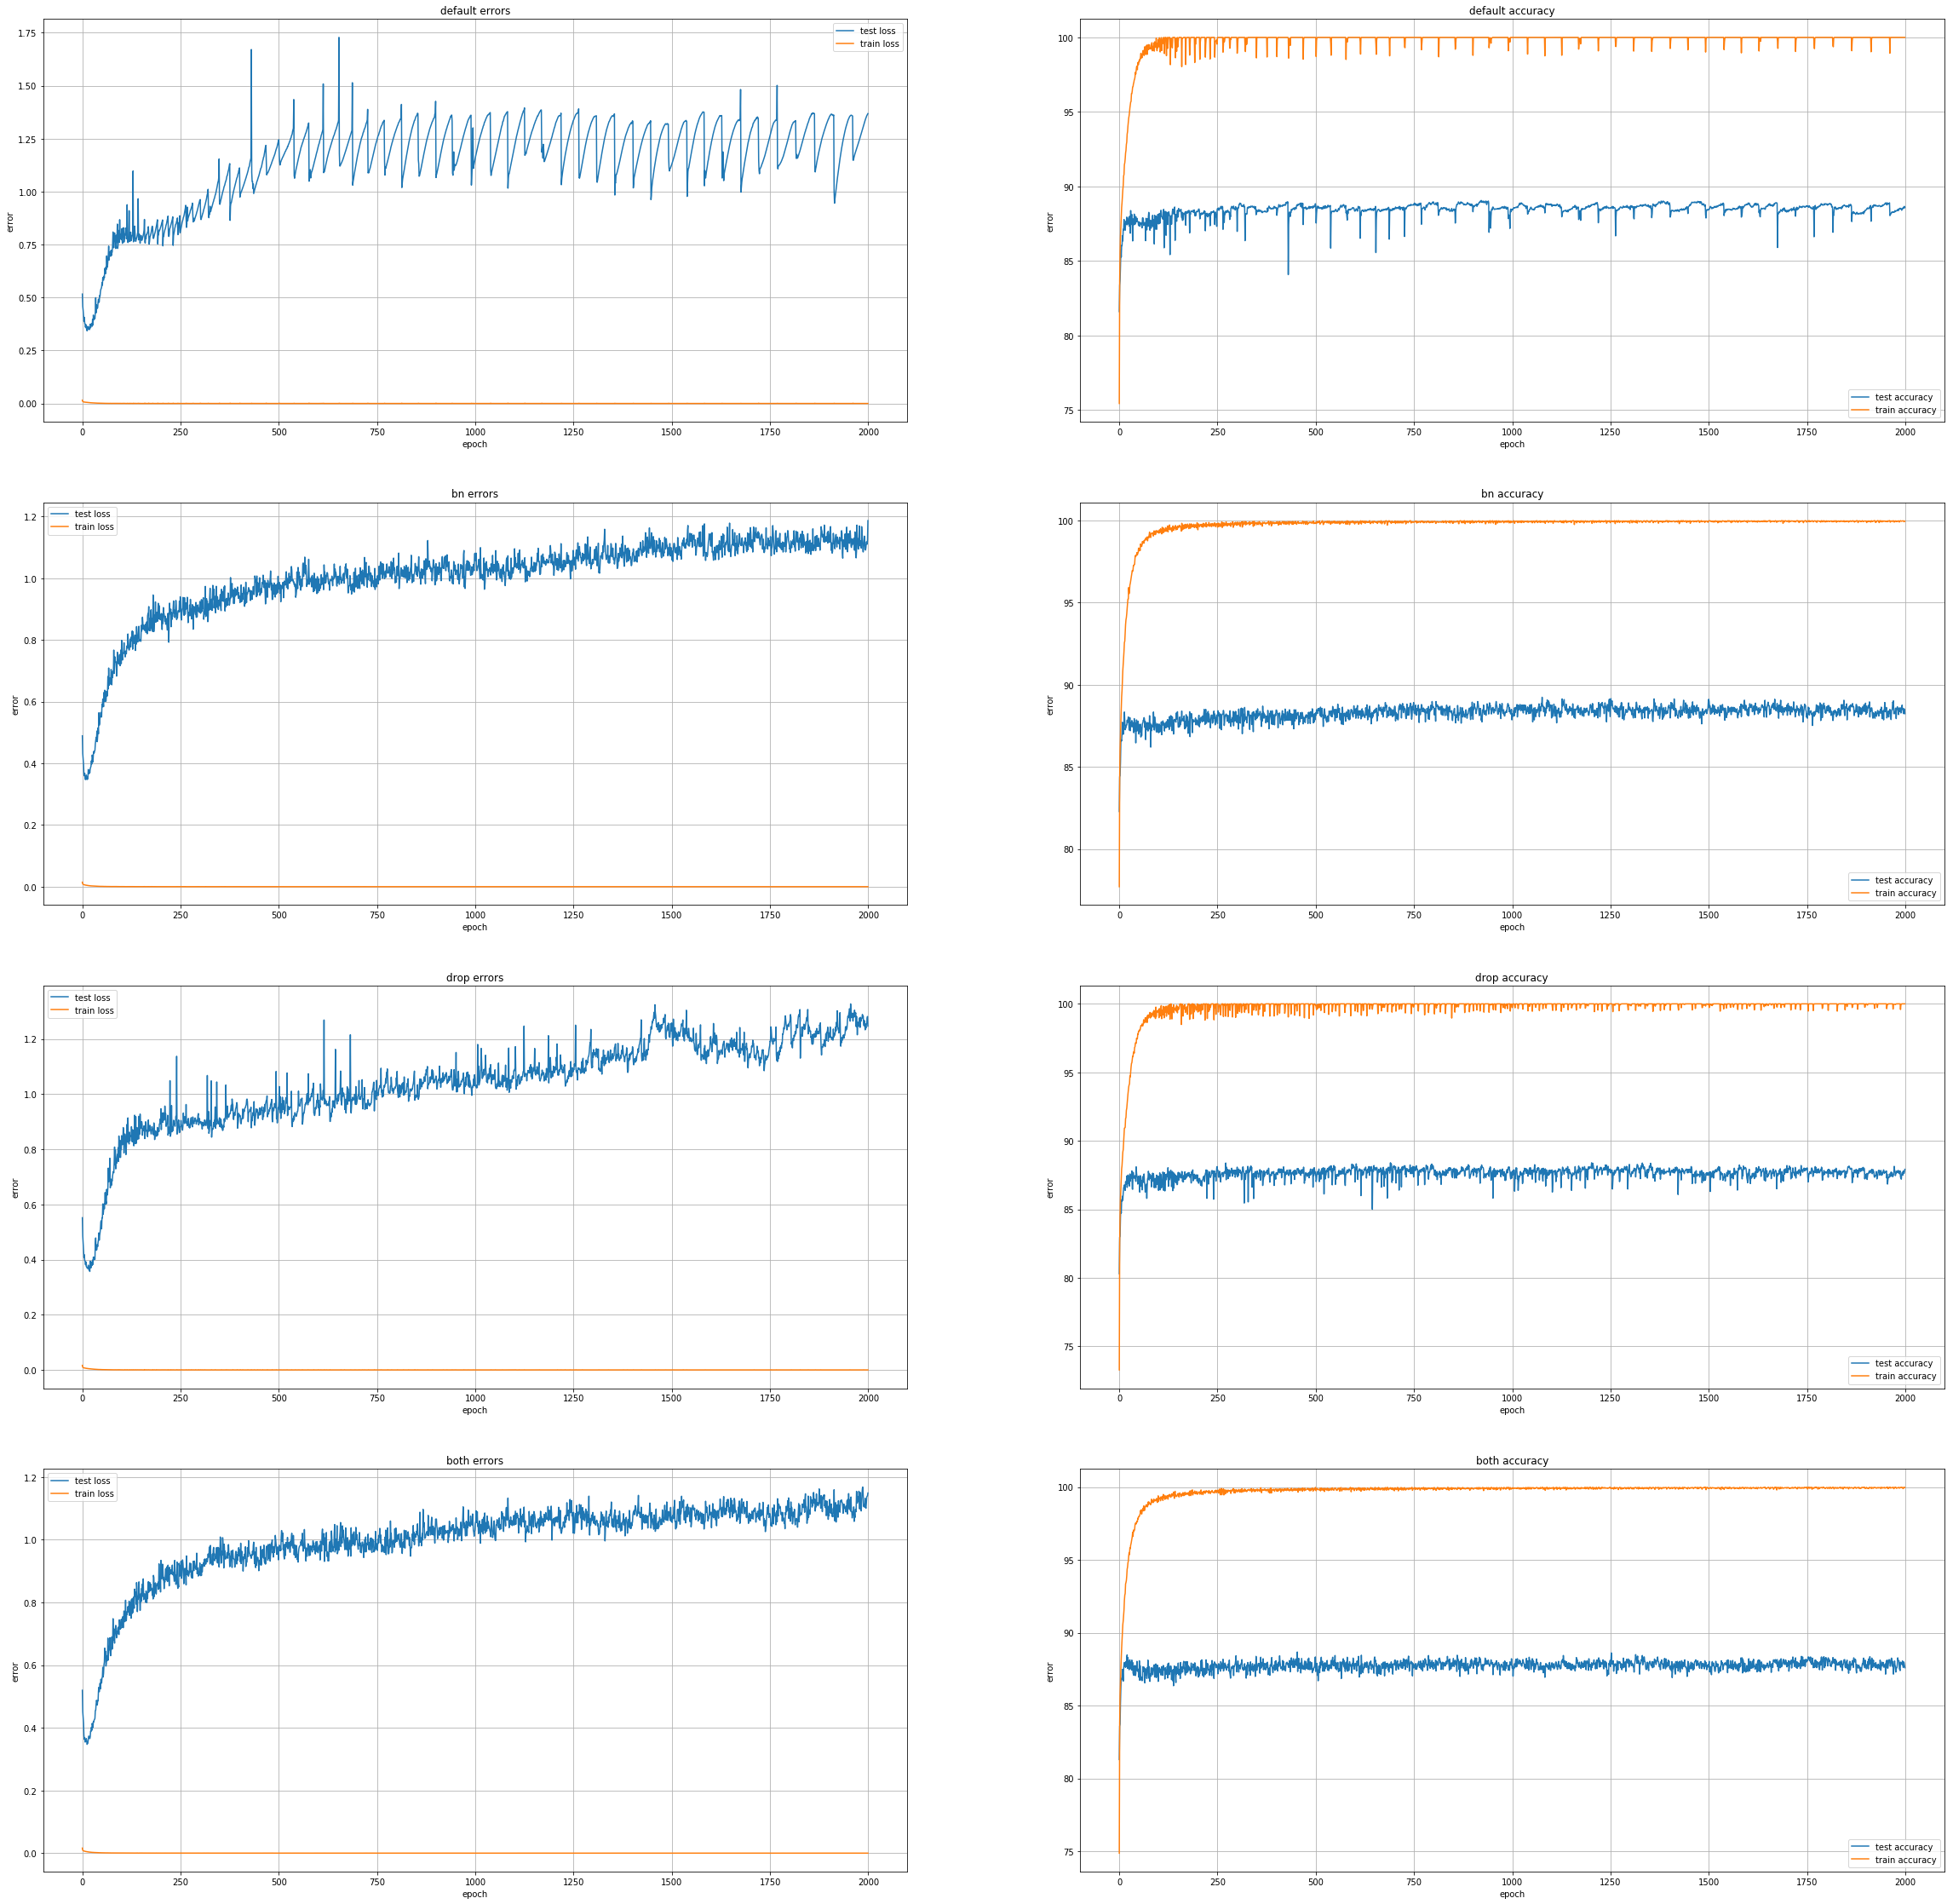

In [48]:
plt.rcParams['figure.figsize'] = [40, 40]
plot_compare_logs(test_log, train_log)